<div style="font-family:monospace; font-size:15px; line-height:1.5; border-top: 1px solid black; border-bottom: 1px solid black; padding: 10px; text-align: center;">
    <strong>ADAM-SINDy OPTIMIZATION - DYNAMICAL SYSTEM IDENTIFICATION</strong><br>
    <strong></strong> SIVA VIKNESH & YOUNES TATARI <br>
    <strong></strong> siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com<br>
    <strong></strong> SCIENTIFIC COMPUTING & IMAGING INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA<br>
</div>


In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


Two dimensional form of Van der pol oscillator:  <br>
Book: Understanding Nonlinear Dynamics By Daniel Kaplan, Leon Glass · 2012
$$
\begin{aligned}
\dot{x} & = y  \\
\dot{y} & = mu(1 - x^a)y -x \\
\end{aligned}
$$

Parameters: \\(mu\\) , \\(a\\)

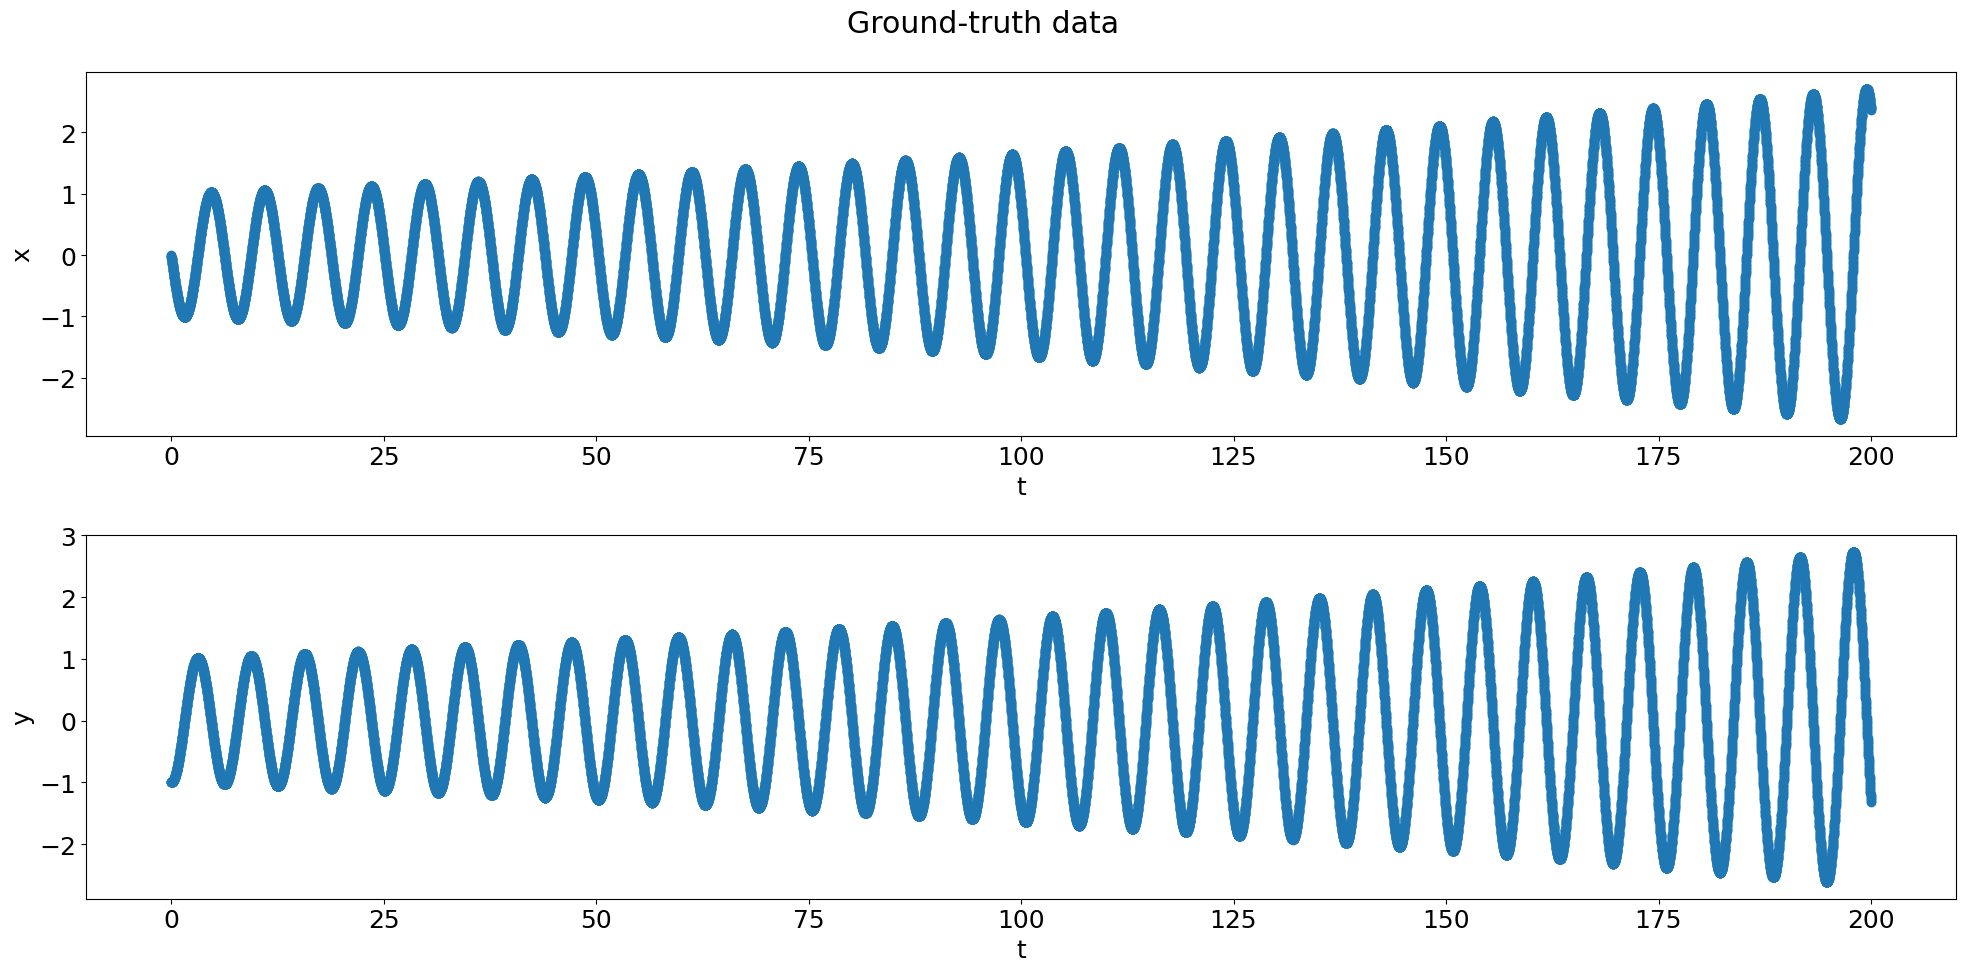

In [2]:
dt = 0.01
T  = 200
t  = np.arange(0,T+dt,dt)
mu = 0.01
a  = 2.15

def oscillator_deriv(x_y, t0, a = a, mu = mu):
    x, y = x_y
    x_powered = np.sign(x) * np.power(np.abs(x), a)
    dxdt = y
    dydt = mu*(1 - x_powered)*y - x
    return [dxdt, dydt]

np.random.seed(123)
x0 = (0, -1)
x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o')
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o')
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

fig.tight_layout()
plt.show()

In [3]:
# COMPUTING THE COMBINATIONS AMONG THE THREE CHOSEN TEMPORAL MODES

def POOL_DATA(yin, nVars, polyorder):
    n = yin.shape[0]
    yout = torch.zeros((n, 1)).to(processor)

    # poly order 0
    yout[:, 0] = torch.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = torch.cat((yout, yin[:, i].reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout = torch.cat((yout, (yin[:, i] * yin[:, j]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    yout = torch.cat((yout, (yin[:, i] * yin[:, j] * yin[:, k]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    return yout

def DERIVATIVE(x, y, a, mu):
    x_powered = torch.sign(x) * torch.pow(torch.abs(x), a)
    dxdt = y
    dydt = mu*(1 - x_powered)*y - x
    return torch.vstack((dxdt, dydt)).T


AVAILABLE PROCESSOR: cuda 



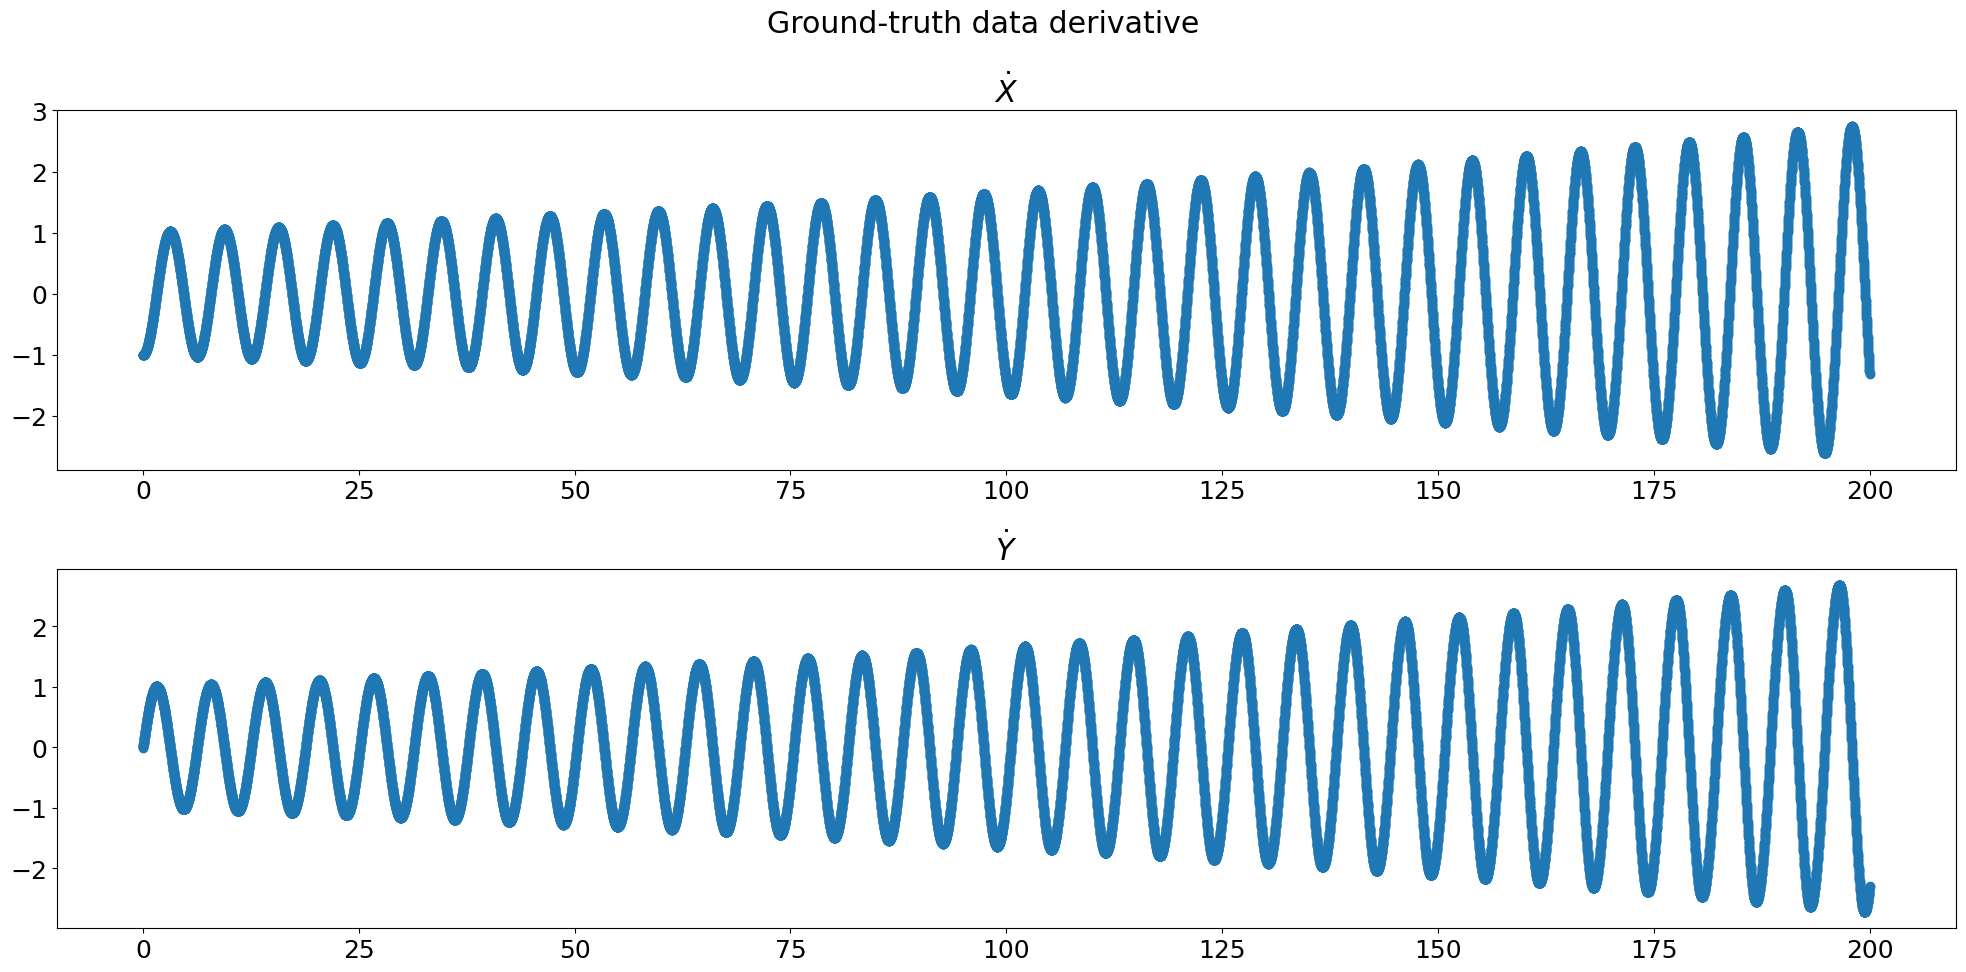

In [4]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

N_modes  = 2
x_t      = torch.Tensor(x_t).to(processor)
x        = torch.Tensor(x).to(processor)
y        = torch.Tensor(y).to(processor)
t        = torch.Tensor(t).to(processor)

A_candidates    = POOL_DATA (x_t, 2, 1).to(processor)
A1A2_time_deriv = DERIVATIVE (x, y, a, mu).to(processor)

# HYPERPARAMETERS FOR THE SINDy POD METHODOLOGY
Epochs        = 32000
learning_rate = 0.01
step_epoch    = 2500
decay_rate    = 0.50
tolerance     = 5e-3


fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 0].detach().cpu().numpy(), '-o')
ax[0].set_title(r"$\dot{X}$")

ax[1].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 1].detach().cpu().numpy(), '-o')
ax[1].set_title(r"$\dot{Y}$")

fig.tight_layout()
plt.show()

In [5]:
class SINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sin(self.b*x)
        return output

class COSINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.cos(self.b*x)
        return output

class POWER_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.mul(torch.sign(x [:, 0]) * torch.pow(torch.abs(x[:, 0]), self.b[0]), torch.sign(x [:, 1]) * torch.pow(torch.abs(x[:, 1]), self.b[1]))
        return output.reshape(-1, 1)
    
class EXP_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.exp(self.b*x)
        return output

In [6]:
class ADAM_SINDy_MODEL(nn.Module):
    def __init__(self, a, asine, acosine, aexp, axsine, axcosine, axexp, apower):
        super().__init__()
        self.a        = a
        self.asine    = asine
        self.acosine  = acosine
        self.aexp     = aexp
        self.axsine   = axsine
        self.axcosine = axcosine
        self.axexp    = axexp
        self.apower   = apower

        self.sine     = SINE_TERM   (self.asine)
        self.cosine   = COSINE_TERM (self.acosine)
        self.exp      = EXP_TERM    (self.aexp)
        self.xsine    = SINE_TERM   (self.axsine)
        self.xcosine  = COSINE_TERM (self.axcosine)
        self.xexp     = EXP_TERM    (self.axexp)
        self.power    = POWER_TERM  (self.apower)

    def forward(self, x):
        x1             = x [:, 1:]
        output_sine    = self.sine    (x1)
        output_cosine  = self.cosine  (x1)
        output_exp     = self.exp     (x1)
        output_xsine   = self.xsine   (x1)
        output_xcosine = self.xcosine (x1)
        output_xexp    = self.xexp    (x1)
        output_power   = self.power   (x1)

        output_xsine   = (output_xsine  [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xcosine = (output_xcosine[:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xexp    = (output_xexp   [:,None] * x1[...,None]).reshape(x1.shape[0], -1)

        output = torch.hstack((x, output_sine, output_cosine, output_exp, output_xsine, output_xcosine, output_xexp, output_power)) @ self.a
        return output


In [7]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(22, N_modes, requires_grad = True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad = True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad = True, device= processor)

XSINE_ADT   = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad = True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad = True, device= processor)

EXP_ADT     = torch.full((A_candidates.shape[1]-1, N_modes), -1.0, requires_grad = True, device= processor)
XEXP_ADT    = torch.full((A_candidates.shape[1]-1, N_modes), -1.0, requires_grad = True, device= processor)
POWER_ADT   = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad = True, device= processor)

In [8]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, SINE_ADT, COSINE_ADT, EXP_ADT, XSINE_ADT, XCOSINE_ADT, XEXP_ADT, POWER_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
torch.manual_seed(34)
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
nn.init.normal_(WEIGHTS, mean=0, std=1.0)
Lambda   = Parameter(torch.tensor(1.0), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda],  lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)


**Adaptive SINDy training**

In [9]:
# TEMPORAL MODE 1
A1_DT = ADAM_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0], EXP_ADT[:, 0], XSINE_ADT [:, 0], XCOSINE_ADT[:, 0], XEXP_ADT [:, 0], POWER_ADT [:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAM_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1], EXP_ADT[:, 1], XSINE_ADT [:, 1], XCOSINE_ADT[:, 1], XEXP_ADT [:, 1], POWER_ADT [:, 1]).to(processor)

Loss_data     = torch.empty(size=(Epochs, 1))
Gamma_correct   = torch.empty(size=(Epochs, 1))
Gamma_incorrect = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    A1_out, A2_out  = A1_DT (A_candidates), A2_DT (A_candidates)
    output_data  = torch.stack((A1_out , A2_out), dim = 1)
    loss_epoch   = loss_function (A1A2_time_deriv, output_data) + torch.linalg.matrix_norm(torch.abs(WEIGHTS)*COEFF_ADT, ord =1)

    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    optim_weights.zero_grad()
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()
        optim_weights.step()
        Loss_data [epoch] = loss_epoch.detach()
        Gamma_incorrect [epoch] = WEIGHTS [0, 0].detach()
        Gamma_correct   [epoch] = WEIGHTS [2, 0].detach()
        COEFF_ADT   [torch.abs(COEFF_ADT)   <= tolerance] = 0.0
        SINE_ADT    [torch.abs(SINE_ADT)    <= tolerance] = 0.0
        COSINE_ADT  [torch.abs(COSINE_ADT)  <= tolerance] = 0.0
        XSINE_ADT   [torch.abs(XSINE_ADT)   <= tolerance] = 0.0
        XCOSINE_ADT [torch.abs(XCOSINE_ADT) <= tolerance] = 0.0
        EXP_ADT     [torch.abs(EXP_ADT)     <= tolerance] = 0.0
        XEXP_ADT    [torch.abs(XEXP_ADT)    <= tolerance] = 0.0
        POWER_ADT   [torch.abs(POWER_ADT)   <= tolerance] = 0.0

    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)

    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

LOSS DATA, [EPOCH = 0 ]: 125.10787963867188
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1 ]: 117.29995727539062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2 ]: 110.09475708007812
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3 ]: 103.47801971435547
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4 ]: 97.43351745605469
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 5 ]: 91.95223236083984
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 6 ]: 87.01112365722656
LEARNING RATE: 0.01
***************************************

LOSS DATA, [EPOCH = 78 ]: 12.498577117919922
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 79 ]: 12.25411605834961
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 80 ]: 12.002426147460938
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 81 ]: 11.747576713562012
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 82 ]: 11.511641502380371
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 83 ]: 11.28056526184082
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 84 ]: 11.043882369995117
LEARNING RATE: 0.01
*******************************

LOSS DATA, [EPOCH = 152 ]: 2.780722141265869
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 153 ]: 2.7276978492736816
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 154 ]: 2.681633472442627
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 155 ]: 2.63602352142334
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 156 ]: 2.592552423477173
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 157 ]: 2.539827823638916
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 158 ]: 2.498332977294922
LEARNING RATE: 0.01
*****************************

LOSS DATA, [EPOCH = 231 ]: 0.8770891427993774
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 232 ]: 0.8724444508552551
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 233 ]: 0.8682436943054199
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 234 ]: 0.8603867292404175
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 235 ]: 0.8543444275856018
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 236 ]: 0.8462015986442566
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 237 ]: 0.8336083889007568
LEARNING RATE: 0.01
**********************

LOSS DATA, [EPOCH = 306 ]: 0.47516483068466187
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 307 ]: 0.4735182523727417
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 308 ]: 0.472738653421402
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 309 ]: 0.47013628482818604
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 310 ]: 0.46695101261138916
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 311 ]: 0.46224862337112427
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 312 ]: 0.45828062295913696
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 380 ]: 0.3247026801109314
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 381 ]: 0.3222543001174927
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 382 ]: 0.31842851638793945
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 383 ]: 0.31567761301994324
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 384 ]: 0.3119122385978699
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 385 ]: 0.309604287147522
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 386 ]: 0.31012848019599915
LEARNING RATE: 0.01
********************

LOSS DATA, [EPOCH = 455 ]: 0.17443305253982544
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 456 ]: 0.1722331941127777
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 457 ]: 0.16880585253238678
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 458 ]: 0.167353093624115
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 459 ]: 0.1649683266878128
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 460 ]: 0.1636631041765213
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 461 ]: 0.16206015646457672
LEARNING RATE: 0.01
********************

LOSS DATA, [EPOCH = 530 ]: 0.0631958395242691
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 531 ]: 0.06063828617334366
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 532 ]: 0.05617035925388336
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 533 ]: 0.05493002384901047
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 534 ]: 0.056152500212192535
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 535 ]: 0.05536539480090141
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 536 ]: 0.05604732781648636
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 605 ]: 0.023517221212387085
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 606 ]: 0.024595092982053757
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 607 ]: 0.023229222744703293
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 608 ]: 0.02155575528740883
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 609 ]: 0.023633204400539398
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 610 ]: 0.02465127408504486
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 611 ]: 0.022983256727457047
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 680 ]: 0.01405327022075653
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 681 ]: 0.01348884031176567
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 682 ]: 0.014932146295905113
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 683 ]: 0.016838358715176582
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 684 ]: 0.016476944088935852
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 685 ]: 0.01736985519528389
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 686 ]: 0.015104170888662338
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 755 ]: 0.010313841514289379
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 756 ]: 0.009901396930217743
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 757 ]: 0.009461470879614353
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 758 ]: 0.01002043578773737
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 759 ]: 0.011146117001771927
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 760 ]: 0.010729298926889896
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 761 ]: 0.011714648455381393
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 830 ]: 0.00756330881267786
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 831 ]: 0.009410008788108826
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 832 ]: 0.007359505631029606
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 833 ]: 0.009114938788115978
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 834 ]: 0.010373000986874104
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 835 ]: 0.011481015011668205
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 836 ]: 0.011345607228577137
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 905 ]: 0.010105445049703121
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 906 ]: 0.009717129170894623
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 907 ]: 0.00853023212403059
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 908 ]: 0.010890691541135311
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 909 ]: 0.00940900482237339
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 910 ]: 0.007820166647434235
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 911 ]: 0.008365673944354057
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 981 ]: 0.004075103905051947
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 982 ]: 0.0023913593031466007
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 983 ]: 0.003948051016777754
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 984 ]: 0.006055416073650122
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 985 ]: 0.005612199194729328
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 986 ]: 0.004886914044618607
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 987 ]: 0.0036956053227186203
LEARNING RATE: 0.01
******

LOSS DATA, [EPOCH = 1055 ]: 0.004629987291991711
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1056 ]: 0.004999907221645117
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1057 ]: 0.005616915877908468
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1058 ]: 0.005482970736920834
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1059 ]: 0.005818541627377272
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1060 ]: 0.004332139156758785
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1061 ]: 0.003317020135000348
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 1130 ]: 0.007084611337631941
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1131 ]: 0.006100581493228674
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1132 ]: 0.004588356241583824
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1133 ]: 0.004668470472097397
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1134 ]: 0.006101494655013084
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1135 ]: 0.005659846588969231
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1136 ]: 0.007667361292988062
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 1205 ]: 0.006432283204048872
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1206 ]: 0.0059426696971058846
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1207 ]: 0.0056977588683366776
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1208 ]: 0.005982694681733847
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1209 ]: 0.0033349806908518076
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1210 ]: 0.005594037007540464
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1211 ]: 0.007105707190930843
LEARNING RATE: 0.0

LOSS DATA, [EPOCH = 1280 ]: 0.006865049246698618
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1281 ]: 0.007036268711090088
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1282 ]: 0.004329496994614601
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1283 ]: 0.0038383076898753643
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1284 ]: 0.007090261206030846
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1285 ]: 0.009036929346621037
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1286 ]: 0.007990464568138123
LEARNING RATE: 0.01


LOSS DATA, [EPOCH = 1355 ]: 0.006734936498105526
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1356 ]: 0.007143185939639807
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1357 ]: 0.004781131166964769
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1358 ]: 0.003675503423437476
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1359 ]: 0.004837941378355026
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1360 ]: 0.005244522355496883
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1361 ]: 0.004463357850909233
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 1431 ]: 0.004167018923908472
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1432 ]: 0.004918173421174288
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1433 ]: 0.005378090776503086
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1434 ]: 0.004449131898581982
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1435 ]: 0.003998109605163336
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1436 ]: 0.0066939364187419415
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1437 ]: 0.007020154036581516
LEARNING RATE: 0.01


LOSS DATA, [EPOCH = 1506 ]: 0.0038786742370575666
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1507 ]: 0.002960591809824109
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1508 ]: 0.00341936107724905
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1509 ]: 0.004518126603215933
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1510 ]: 0.0029426447581499815
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1511 ]: 0.0019606053829193115
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1512 ]: 0.002766788937151432
LEARNING RATE: 0.01

LOSS DATA, [EPOCH = 1581 ]: 0.0022591697052121162
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1582 ]: 0.004799709655344486
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1583 ]: 0.004787176847457886
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1584 ]: 0.005264241248369217
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1585 ]: 0.005286126863211393
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1586 ]: 0.004983974155038595
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1587 ]: 0.005057968199253082
LEARNING RATE: 0.01


LOSS DATA, [EPOCH = 1656 ]: 0.005293110851198435
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1657 ]: 0.00424532825127244
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1658 ]: 0.0037644687108695507
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1659 ]: 0.004277654457837343
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1660 ]: 0.006201531272381544
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1661 ]: 0.005955307744443417
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1662 ]: 0.0056717549450695515
LEARNING RATE: 0.01


LOSS DATA, [EPOCH = 1731 ]: 0.003948025871068239
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1732 ]: 0.005079167895019054
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1733 ]: 0.005603715777397156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1734 ]: 0.005456932354718447
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1735 ]: 0.004596394952386618
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1736 ]: 0.003827249864116311
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1737 ]: 0.004410893656313419
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 1804 ]: 0.005149360746145248
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1805 ]: 0.004180686082690954
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1806 ]: 0.0021949042566120625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1807 ]: 0.002489162143319845
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1808 ]: 0.004253708757460117
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1809 ]: 0.005152708850800991
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1810 ]: 0.00454967375844717
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 1879 ]: 0.0027966059278696775
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1880 ]: 0.002304002409800887
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1881 ]: 0.0032344115898013115
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1882 ]: 0.003355344757437706
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1883 ]: 0.004893194418400526
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1884 ]: 0.004130934830754995
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1885 ]: 0.003072597784921527
LEARNING RATE: 0.01

LOSS DATA, [EPOCH = 1954 ]: 0.0022822252940386534
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1955 ]: 0.0016881373012438416
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1956 ]: 0.001688952324911952
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1957 ]: 0.003477435791864991
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1958 ]: 0.0034345947206020355
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1959 ]: 0.0039032669737935066
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1960 ]: 0.0031442244071513414
LEARNING RATE: 0

LOSS DATA, [EPOCH = 2029 ]: 0.003306482918560505
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2030 ]: 0.004224029369652271
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2031 ]: 0.004111795220524073
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2032 ]: 0.002433154731988907
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2033 ]: 0.0023293602280318737
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2034 ]: 0.0033902653958648443
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2035 ]: 0.004849003162235022
LEARNING RATE: 0.01

LOSS DATA, [EPOCH = 2104 ]: 0.00312002282589674
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2105 ]: 0.005607930012047291
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2106 ]: 0.006233170162886381
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2107 ]: 0.004993356764316559
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2108 ]: 0.003551560454070568
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2109 ]: 0.0017073418712243438
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2110 ]: 0.003339598421007395
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 2157 ]: 0.0036359948571771383
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2158 ]: 0.004790966864675283
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2159 ]: 0.004252986516803503
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2160 ]: 0.0022930230479687452
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2161 ]: 0.0027938929852098227
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2162 ]: 0.004437935538589954
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2163 ]: 0.005265108309686184
LEARNING RATE: 0.0

LOSS DATA, [EPOCH = 2232 ]: 0.003029498504474759
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2233 ]: 0.00396921718493104
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2234 ]: 0.003253920003771782
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2235 ]: 0.002943972824141383
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2236 ]: 0.0023689656518399715
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2237 ]: 0.003271979745477438
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2238 ]: 0.003261337522417307
LEARNING RATE: 0.01
*

LOSS DATA, [EPOCH = 2314 ]: 0.001242974540218711
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2315 ]: 0.0016677272506058216
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2316 ]: 0.0028886606451123953
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2317 ]: 0.0029335860162973404
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2318 ]: 0.001326803583651781
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2319 ]: 0.001939383801072836
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2320 ]: 0.0030458741821348667
LEARNING RATE: 0.

LOSS DATA, [EPOCH = 2377 ]: 0.0036016805097460747
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2378 ]: 0.003584445919841528
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2379 ]: 0.004366201814264059
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2380 ]: 0.0028104365337640047
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2381 ]: 0.002697200980037451
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2382 ]: 0.0032154840882867575
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2383 ]: 0.0031565057579427958
LEARNING RATE: 0.

LOSS DATA, [EPOCH = 2452 ]: 0.001151460688561201
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2453 ]: 0.001920104492455721
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2454 ]: 0.0031779438722878695
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2455 ]: 0.003383674891665578
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2456 ]: 0.00213612406514585
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2457 ]: 0.003782972926273942
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2458 ]: 0.0025989445857703686
LEARNING RATE: 0.01


LOSS DATA, [EPOCH = 2526 ]: 0.0010898169130086899
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2527 ]: 0.0018322996329516172
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2528 ]: 0.002178024500608444
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2529 ]: 0.0019130208529531956
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2530 ]: 0.0015230748103931546
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2531 ]: 0.0007197021041065454
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2532 ]: 0.0011977865360677242
LEARNING 

LOSS DATA, [EPOCH = 2601 ]: 0.0018801733385771513
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2602 ]: 0.0014161919243633747
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2603 ]: 0.0006125975050963461
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2604 ]: 0.0010240853298455477
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2605 ]: 0.0017470144666731358
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2606 ]: 0.002108063781633973
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2607 ]: 0.0018362787086516619
LEARNING 

LOSS DATA, [EPOCH = 2676 ]: 0.0017581998836249113
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2677 ]: 0.00222602067515254
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2678 ]: 0.0019432635745033622
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2679 ]: 0.0024157147854566574
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2680 ]: 0.002219048561528325
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2681 ]: 0.0013409937964752316
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2682 ]: 0.0014482267433777452
LEARNING RA

LOSS DATA, [EPOCH = 2751 ]: 0.002210451290011406
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2752 ]: 0.001923822914250195
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2753 ]: 0.0009554090793244541
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2754 ]: 0.0013126636622473598
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2755 ]: 0.002238683635368943
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2756 ]: 0.0028104062657803297
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2757 ]: 0.002546411007642746
LEARNING RAT

LOSS DATA, [EPOCH = 2826 ]: 0.001089088269509375
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2827 ]: 0.0016698352992534637
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2828 ]: 0.002277964958921075
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2829 ]: 0.00212896429002285
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2830 ]: 0.0012884523021057248
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2831 ]: 0.000927068991586566
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2832 ]: 0.001645161653868854
LEARNING RATE:

LOSS DATA, [EPOCH = 2901 ]: 0.0018342719413340092
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2902 ]: 0.0011032017646357417
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2903 ]: 0.00028298390679992735
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2904 ]: 0.0009414736414328218
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2905 ]: 0.0017351779388263822
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2906 ]: 0.002122987760230899
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2907 ]: 0.0018118122825399041
LEARNING

LOSS DATA, [EPOCH = 2976 ]: 0.0012106022331863642
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2977 ]: 0.0018721430096775293
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2978 ]: 0.001984117552638054
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2979 ]: 0.0019183114636689425
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2980 ]: 0.00149231415707618
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2981 ]: 0.0005949968472123146
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 2982 ]: 0.0010834366548806429
LEARNING RA

LOSS DATA, [EPOCH = 3051 ]: 0.0006355034420266747
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3052 ]: 0.0002761711657512933
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3053 ]: 0.00047973604523576796
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3054 ]: 0.0010060843778774142
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3055 ]: 0.0008267672383226454
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3056 ]: 0.0006793735665269196
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3057 ]: 0.0005423820111900568
LEARNIN

LOSS DATA, [EPOCH = 3126 ]: 0.000940677069593221
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3127 ]: 0.0007634981884621084
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3128 ]: 0.0006438267882913351
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3129 ]: 0.001093449187465012
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3130 ]: 0.001171581563539803
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3131 ]: 0.0013452036073431373
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3132 ]: 0.0011971273925155401
LEARNING RA

LOSS DATA, [EPOCH = 3199 ]: 0.0007903706282377243
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3200 ]: 0.0007011083653196692
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3201 ]: 0.001083408948034048
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3202 ]: 0.0010591769823804498
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3203 ]: 0.0013594173360615969
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3204 ]: 0.0011907676234841347
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3205 ]: 0.0011998603586107492
LEARNING 

LOSS DATA, [EPOCH = 3274 ]: 0.0015234025195240974
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3275 ]: 0.0014200767036527395
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3276 ]: 0.0007939972565509379
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3277 ]: 0.0005514400545507669
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3278 ]: 0.0009916431736201048
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3279 ]: 0.0008482026169076562
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3280 ]: 0.0005116930115036666
LEARNING

LOSS DATA, [EPOCH = 3349 ]: 0.0006258385255932808
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3350 ]: 0.0011719473404809833
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3351 ]: 0.001004250138066709
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3352 ]: 0.0007141198148019612
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3353 ]: 0.000715282279998064
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3354 ]: 0.0009079740848392248
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3355 ]: 0.0007488480769097805
LEARNING R

LOSS DATA, [EPOCH = 3425 ]: 0.0021015149541199207
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3426 ]: 0.002048654481768608
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3427 ]: 0.001813797396607697
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3428 ]: 0.0014825054677203298
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3429 ]: 0.0003921913739759475
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3430 ]: 0.0014670052332803607
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3431 ]: 0.0021632658317685127
LEARNING R

LOSS DATA, [EPOCH = 3501 ]: 0.0011557566467672586
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3502 ]: 0.0012877838453277946
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3503 ]: 0.0013003486674278975
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3504 ]: 0.0013083680532872677
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3505 ]: 0.0007284343591891229
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3506 ]: 0.0009642304503358901
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3507 ]: 0.0008708829991519451
LEARNING

LOSS DATA, [EPOCH = 3562 ]: 0.0003493863623589277
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3563 ]: 0.00036995246773585677
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3564 ]: 0.0004607499286066741
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3565 ]: 0.00048331916332244873
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3566 ]: 0.0008800722425803542
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3567 ]: 0.0008414372568950057
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3568 ]: 0.000929483154322952
LEARNIN

LOSS DATA, [EPOCH = 3622 ]: 0.0007870123372413218
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3623 ]: 0.000859869469422847
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3624 ]: 0.0010131805902346969
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3625 ]: 0.0009803255088627338
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3626 ]: 0.0004504180687945336
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3627 ]: 0.0005553210503421724
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3628 ]: 0.0012221154756844044
LEARNING 

LOSS DATA, [EPOCH = 3697 ]: 0.0009086799691431224
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3698 ]: 0.0004041388747282326
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3699 ]: 0.0006352023920044303
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3700 ]: 0.0013358062133193016
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3701 ]: 0.0012796747032552958
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3702 ]: 0.0005232995608821511
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3703 ]: 0.0010172748006880283
LEARNING

LOSS DATA, [EPOCH = 3772 ]: 0.001796790398657322
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3773 ]: 0.001020630355924368
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3774 ]: 0.0013203038834035397
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3775 ]: 0.0020994769874960184
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3776 ]: 0.0025087555404752493
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3777 ]: 0.0021457963157445192
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3778 ]: 0.0011421305825933814
LEARNING R

LOSS DATA, [EPOCH = 3847 ]: 0.0005080701666884124
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3848 ]: 0.0012123305350542068
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3849 ]: 0.0011633888352662325
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3850 ]: 0.00038302410393953323
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3851 ]: 0.0010612329933792353
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3852 ]: 0.0016137317288666964
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3853 ]: 0.0013803375186398625
LEARNIN

LOSS DATA, [EPOCH = 3920 ]: 0.0014201733283698559
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3921 ]: 0.0008628250216133893
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3922 ]: 0.0007100264192558825
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3923 ]: 0.0007610336178913713
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3924 ]: 0.0008970630005933344
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3925 ]: 0.0008658773731440306
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3926 ]: 0.0003571803099475801
LEARNING

LOSS DATA, [EPOCH = 4009 ]: 0.0012086252681910992
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4010 ]: 0.000435989088146016
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4011 ]: 0.0009803844150155783
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4012 ]: 0.0015278083737939596
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4013 ]: 0.0013030067784711719
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4014 ]: 0.00039103702874854207
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4015 ]: 0.0011345049133524299
LEARNING

LOSS DATA, [EPOCH = 4073 ]: 0.0013530036667361856
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4074 ]: 0.0011558831902220845
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4075 ]: 0.0010849237442016602
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4076 ]: 0.0008973739459179342
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4077 ]: 0.0012306098360568285
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4078 ]: 0.0011631828965619206
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4079 ]: 0.0015333953779190779
LEARNING

LOSS DATA, [EPOCH = 4148 ]: 0.0008138931589201093
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4149 ]: 0.0006522485637106001
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4150 ]: 0.0005711044650524855
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4151 ]: 0.001015559653751552
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4152 ]: 0.0009923577308654785
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4153 ]: 0.0013879103353247046
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4154 ]: 0.0011786518152803183
LEARNING 

LOSS DATA, [EPOCH = 4223 ]: 0.0010929303243756294
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4224 ]: 0.0010697225807234645
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4225 ]: 0.0013723397860303521
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4226 ]: 0.0011745310621336102
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4227 ]: 0.0009592576534487307
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4228 ]: 0.0007752773235552013
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4229 ]: 0.0012042607413604856
LEARNING

LOSS DATA, [EPOCH = 4298 ]: 0.0006711043533869088
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4299 ]: 0.0004533632309176028
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4300 ]: 0.0006820169510319829
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4301 ]: 0.0005186262424103916
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4302 ]: 0.00045997637789696455
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4303 ]: 0.0011473929043859243
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4304 ]: 0.0011255344143137336
LEARNIN

LOSS DATA, [EPOCH = 4373 ]: 0.0002489319595042616
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4374 ]: 0.0007902420475147665
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4375 ]: 0.0006352365016937256
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4376 ]: 0.0002834569022525102
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4377 ]: 0.00029546988662332296
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4378 ]: 0.00044778865412808955
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4379 ]: 0.0003709731681738049
LEARNI

LOSS DATA, [EPOCH = 4448 ]: 0.0009001543512567878
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4449 ]: 0.0007586944266222417
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4450 ]: 0.0006028168136253953
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4451 ]: 0.0008217016002163291
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4452 ]: 0.0009696774068288505
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4453 ]: 0.0008283150964416564
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4454 ]: 0.0007579055964015424
LEARNING

LOSS DATA, [EPOCH = 4523 ]: 0.0015588030219078064
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4524 ]: 0.001509913825429976
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4525 ]: 0.0017109890468418598
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4526 ]: 0.0014100224943831563
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4527 ]: 0.0005529886111617088
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4528 ]: 0.00040511315455660224
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4529 ]: 0.0010090996511280537
LEARNING

LOSS DATA, [EPOCH = 4598 ]: 0.0013085228856652975
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4599 ]: 0.001125185750424862
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4600 ]: 0.00025345347239635885
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4601 ]: 0.0006849910714663565
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4602 ]: 0.0013205865398049355
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4603 ]: 0.0012979398015886545
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4604 ]: 0.0006200907519087195
LEARNING

LOSS DATA, [EPOCH = 4671 ]: 0.001608569989912212
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4672 ]: 0.00107921427115798
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4673 ]: 0.00026466051349416375
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4674 ]: 0.000660522491671145
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4675 ]: 0.0005372563027776778
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4676 ]: 0.0002747153048403561
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4677 ]: 0.0009294897899962962
LEARNING RA

LOSS DATA, [EPOCH = 4746 ]: 0.0002814327890519053
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4747 ]: 0.0006763722631148994
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4748 ]: 0.0010710321366786957
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4749 ]: 0.0008877651998773217
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4750 ]: 0.00038922938983887434
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4751 ]: 0.0006647526752203703
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4752 ]: 0.001376225147396326
LEARNING

LOSS DATA, [EPOCH = 4801 ]: 0.0001930965663632378
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4802 ]: 0.000673227827064693
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4803 ]: 0.0005026204162277281
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4804 ]: 0.000358368648448959
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4805 ]: 0.00042774371104314923
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4806 ]: 0.00022222560073714703
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4807 ]: 0.0002159912110073492
LEARNING

LOSS DATA, [EPOCH = 4861 ]: 0.0010964180110022426
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4862 ]: 0.0009287595748901367
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4863 ]: 0.0004047351249027997
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4864 ]: 0.0007266373722814023
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4865 ]: 0.0007131780730560422
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4866 ]: 8.425425039604306e-05
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4867 ]: 0.0007252715877257288
LEARNING

LOSS DATA, [EPOCH = 4940 ]: 0.00028528302209451795
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4941 ]: 0.0007181977853178978
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4942 ]: 0.0011674020206555724
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4943 ]: 0.0009470487711951137
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4944 ]: 0.00041013609734363854
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4945 ]: 0.0007093827589415014
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4946 ]: 0.0013959662755951285
LEARNI

LOSS DATA, [EPOCH = 5015 ]: 0.0003851696092169732
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5016 ]: 0.0005662192706950009
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5017 ]: 0.0004703883605543524
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5018 ]: 0.0001727340422803536
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5019 ]: 0.0004829468089155853
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5020 ]: 0.0007482082583010197
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5021 ]: 0.0007143114926293492
LE

LOSS DATA, [EPOCH = 5090 ]: 0.00014309360994957387
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5091 ]: 0.00027567133656702936
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5092 ]: 0.0005567463231272995
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5093 ]: 0.0004686257161665708
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5094 ]: 0.00032225673203356564
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5095 ]: 0.00035507764550857246
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5096 ]: 0.000351092487107962

LOSS DATA, [EPOCH = 5165 ]: 0.0011474504135549068
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5166 ]: 0.0006329439929686487
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5167 ]: 0.00018801045371219516
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5168 ]: 0.0005581033765338361
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5169 ]: 0.0005367719568312168
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5170 ]: 0.0001592389162397012
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5171 ]: 0.0005343720549717546
L

LOSS DATA, [EPOCH = 5240 ]: 0.000516741129104048
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5241 ]: 0.0004930825671181083
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5242 ]: 0.00012387507013045251
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5243 ]: 0.00027008194592781365
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5244 ]: 0.0005952997598797083
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5245 ]: 0.0005075051449239254
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5246 ]: 0.0005602245219051838
L

LOSS DATA, [EPOCH = 5315 ]: 0.00044869017438031733
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5316 ]: 0.0003748679009731859
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5317 ]: 0.00041513555333949625
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5318 ]: 0.00047878449549898505
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5319 ]: 0.0004577138170134276
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5320 ]: 0.0001786514330888167
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5321 ]: 0.0003012834931723773

LOSS DATA, [EPOCH = 5388 ]: 0.0003248694119974971
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5389 ]: 0.0005138518754392862
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5390 ]: 0.00044727965723723173
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5391 ]: 0.0005456183571368456
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5392 ]: 0.0003150996344629675
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5393 ]: 0.000527893949765712
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5394 ]: 0.0006717145442962646
LE

LOSS DATA, [EPOCH = 5463 ]: 0.0006103728082962334
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5464 ]: 0.00046937790466472507
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5465 ]: 0.00031962504726834595
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5466 ]: 0.00031980942003428936
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5467 ]: 0.0004894182784482837
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5468 ]: 0.0004373288538772613
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5469 ]: 0.0003596259921323508

LOSS DATA, [EPOCH = 5538 ]: 0.0006364171858876944
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5539 ]: 0.0006055599660612643
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5540 ]: 0.0005913578206673265
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5541 ]: 0.0007765068439766765
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5542 ]: 0.0007317124400287867
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5543 ]: 0.0003244633262511343
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5544 ]: 0.00024544046027585864
L

LOSS DATA, [EPOCH = 5613 ]: 0.00012041968147968873
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5614 ]: 0.00032634419039823115
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5615 ]: 0.0002596255508251488
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5616 ]: 0.00023526058066636324
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5617 ]: 0.0002396402123849839
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5618 ]: 0.00015806358715053648
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5619 ]: 0.000160825278726406

LOSS DATA, [EPOCH = 5688 ]: 0.0006986689986661077
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5689 ]: 0.0002781120128929615
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5690 ]: 0.00020748699898831546
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5691 ]: 0.000486033852212131
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5692 ]: 0.0005334969609975815
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5693 ]: 0.0005236135912127793
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5694 ]: 0.0002670892281457782
LE

LOSS DATA, [EPOCH = 5741 ]: 0.0005679661990143359
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5742 ]: 0.00032840692438185215
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5743 ]: 0.0003032881359104067
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5744 ]: 0.00032167552853934467
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5745 ]: 0.00029705362976528704
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5746 ]: 0.00017141169519163668
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5747 ]: 0.000393328722566366

LOSS DATA, [EPOCH = 5810 ]: 0.00014651338278781623
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5811 ]: 0.0005845400155521929
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5812 ]: 0.0008664123597554862
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5813 ]: 0.0007492187432944775
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5814 ]: 0.0002866817230824381
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5815 ]: 0.0005045422003604472
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5816 ]: 0.0008406757842749357
L

LOSS DATA, [EPOCH = 5886 ]: 0.0002817483327817172
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5887 ]: 0.00022081386123318225
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5888 ]: 0.0005615175468847156
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5889 ]: 0.0005328175611793995
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5890 ]: 0.00014658962027169764
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5891 ]: 0.0005890197353437543
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5892 ]: 0.0008630086085759103


LOSS DATA, [EPOCH = 5943 ]: 0.0002260432083858177
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5944 ]: 0.0004291193909011781
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5945 ]: 0.00040244939737021923
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5946 ]: 0.00020867364946752787
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5947 ]: 0.00047336684656329453
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5948 ]: 0.0005623769829981029
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 5949 ]: 0.0004735976108349859

LOSS DATA, [EPOCH = 6018 ]: 0.0005428994190879166
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6019 ]: 0.0007760492153465748
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6020 ]: 0.0007258738623932004
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6021 ]: 0.00046135924640111625
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6022 ]: 0.000391824112739414
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6023 ]: 0.0004219324910081923
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6024 ]: 0.0003835101961158216
LE

LOSS DATA, [EPOCH = 6093 ]: 0.0007552566239610314
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6094 ]: 0.0003021692100446671
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6095 ]: 0.00047073763562366366
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6096 ]: 0.0007931062136776745
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6097 ]: 0.0007435043225996196
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6098 ]: 0.0003496103163342923
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6099 ]: 0.0003522705810610205
L

LOSS DATA, [EPOCH = 6170 ]: 0.0005246679065749049
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6171 ]: 0.0006903904723003507
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6172 ]: 0.0006013627862557769
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6173 ]: 0.0006292352336458862
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6174 ]: 0.0005997056723572314
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6175 ]: 0.0006716191419400275
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6176 ]: 0.0006310298340395093
LE

LOSS DATA, [EPOCH = 6245 ]: 0.0005448826123028994
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6246 ]: 0.00040878858999349177
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6247 ]: 0.0003121706540696323
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6248 ]: 0.00030774861807003617
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6249 ]: 0.0005693829152733088
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6250 ]: 0.0004858403408434242
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6251 ]: 0.000706589431501925
L

LOSS DATA, [EPOCH = 6322 ]: 0.0004758706199936569
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6323 ]: 0.0007053136359900236
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6324 ]: 0.0006130443653091788
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6325 ]: 0.0007771834498271346
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6326 ]: 0.0007300949655473232
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6327 ]: 0.00066974206129089
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6328 ]: 0.0006276831263676286
LEAR

LOSS DATA, [EPOCH = 6391 ]: 0.00037582335062325
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6392 ]: 0.0003554831200744957
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6393 ]: 0.0005966852768324316
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6394 ]: 0.000508219818584621
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6395 ]: 0.0007023939397186041
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6396 ]: 0.0006143652135506272
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6397 ]: 0.0006417720578610897
LEARN

LOSS DATA, [EPOCH = 6466 ]: 0.00042430756730027497
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6467 ]: 0.0007076835609041154
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6468 ]: 0.0006166108069010079
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6469 ]: 0.000740423914976418
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6470 ]: 0.0007075555622577667
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6471 ]: 0.0006280933157540858
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6472 ]: 0.0005832349415868521
LE

LOSS DATA, [EPOCH = 6541 ]: 0.0004087517154403031
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6542 ]: 0.0002799940120894462
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6543 ]: 0.0004398283490445465
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6544 ]: 0.0005305765080265701
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6545 ]: 0.00039862931589595973
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6546 ]: 0.00034070166293531656
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6547 ]: 0.0003283919068053365


LOSS DATA, [EPOCH = 6616 ]: 0.0007630091276951134
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6617 ]: 0.0007119170622900128
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6618 ]: 0.00031846226193010807
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6619 ]: 0.00037914796848781407
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6620 ]: 0.000664158258587122
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6621 ]: 0.0005809908034279943
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6622 ]: 0.00033863275893963873


LOSS DATA, [EPOCH = 6691 ]: 0.00026175397215411067
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6692 ]: 0.0002025959693128243
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6693 ]: 0.0004243602743372321
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6694 ]: 0.0006439496064558625
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6695 ]: 0.0006173672736622393
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6696 ]: 0.0002599706931505352
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6697 ]: 0.00016241741832345724


LOSS DATA, [EPOCH = 6749 ]: 0.0005659866728819907
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6750 ]: 0.000547317264135927
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6751 ]: 0.0007325399201363325
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6752 ]: 0.0006421005236916244
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6753 ]: 0.0005187313654460013
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6754 ]: 0.00042847084114328027
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6755 ]: 0.0005205206689424813
LE

LOSS DATA, [EPOCH = 6816 ]: 0.00031567944097332656
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6817 ]: 0.0002082235150737688
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6818 ]: 0.00036735154571942985
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6819 ]: 0.00028588809072971344
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6820 ]: 0.00020878743089269847
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6821 ]: 0.0005570348585024476
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6822 ]: 0.000545875926036387

LOSS DATA, [EPOCH = 6879 ]: 0.0005266963271424174
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6880 ]: 0.00016795894771348685
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6881 ]: 0.0003390953061170876
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6882 ]: 0.0006627356051467359
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6883 ]: 0.0006161892088130116
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6884 ]: 0.00043353225919418037
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6885 ]: 0.00015946094936225563

LOSS DATA, [EPOCH = 6944 ]: 0.0005282112979330122
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6945 ]: 0.0008482359116896987
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6946 ]: 0.0008113489020615816
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6947 ]: 0.0005258555756881833
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6948 ]: 0.0004497050540521741
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6949 ]: 0.00026560467085801065
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6950 ]: 0.00034666064311750233


LOSS DATA, [EPOCH = 7016 ]: 0.0005617087590508163
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7017 ]: 0.0008175764814950526
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7018 ]: 0.0006934181437827647
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7019 ]: 0.0009205315145663917
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7020 ]: 0.0008080069674178958
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7021 ]: 0.0006461602752096951
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7022 ]: 0.0006107658846303821
LE

LOSS DATA, [EPOCH = 7081 ]: 0.0006661229417659342
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7082 ]: 0.00027818133821710944
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7083 ]: 0.0004308620991650969
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7084 ]: 0.0007028230465948582
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7085 ]: 0.0006227135309018195
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7086 ]: 0.00034162879455834627
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7087 ]: 0.00019530532881617546

LOSS DATA, [EPOCH = 7156 ]: 0.0004250728525221348
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7157 ]: 0.00047820020699873567
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7158 ]: 0.0004858418833464384
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7159 ]: 0.00048150733346119523
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7160 ]: 0.000402189907617867
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7161 ]: 0.00025479920441284776
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7162 ]: 0.00030374201014637947

LOSS DATA, [EPOCH = 7231 ]: 0.0007268989575095475
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7232 ]: 0.0006682718521915376
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7233 ]: 0.0005864535924047232
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7234 ]: 0.000483441079268232
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7235 ]: 0.0003730160533450544
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7236 ]: 0.00045549191418103874
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7237 ]: 0.0004523550160229206
LE

LOSS DATA, [EPOCH = 7306 ]: 0.0006024792673997581
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7307 ]: 0.0006842126022092998
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7308 ]: 0.0006043807370588183
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7309 ]: 0.0005063553689979017
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7310 ]: 0.0004128831787966192
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7311 ]: 0.0005114265368320048
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7312 ]: 0.0005107689648866653
LE

LOSS DATA, [EPOCH = 7381 ]: 0.000608185597229749
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7382 ]: 0.0005911352345719934
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7383 ]: 0.0007360285380855203
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7384 ]: 0.0006457469426095486
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7385 ]: 0.0004698662378359586
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7386 ]: 0.00037868969957344234
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7387 ]: 0.0005026782164350152
LE

LOSS DATA, [EPOCH = 7456 ]: 0.0005209788796491921
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7457 ]: 0.00042312245932407677
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7458 ]: 0.00032168920733965933
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7459 ]: 0.0004896690952591598
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7460 ]: 0.00048623234033584595
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7461 ]: 0.0007106349803507328
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7462 ]: 0.0006475370028056204

LOSS DATA, [EPOCH = 7537 ]: 0.000192143939784728
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7538 ]: 9.672739543020725e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7539 ]: 0.00018348988669458777
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7540 ]: 0.0003486985806375742
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7541 ]: 0.00035407376708462834
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7542 ]: 0.00017624486645217985
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7543 ]: 0.00016459940525

LOSS DATA, [EPOCH = 7609 ]: 0.00022833638649899513
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7610 ]: 6.185442907735705e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7611 ]: 0.00016755974502302706
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7612 ]: 0.00031394476536661386
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7613 ]: 0.0002850446617230773
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7614 ]: 0.00022969888232182711
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7615 ]: 0.000109581618

LOSS DATA, [EPOCH = 7682 ]: 0.0002898247039411217
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7683 ]: 0.000261192413745448
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7684 ]: 0.00024698127526789904
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7685 ]: 0.00011016079224646091
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7686 ]: 0.00010012395796366036
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7687 ]: 0.00022398815781343728
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7688 ]: 0.0002373738097

LOSS DATA, [EPOCH = 7757 ]: 0.00022624807024840266
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7758 ]: 0.0002485717413946986
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7759 ]: 0.00022292532958090305
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7760 ]: 4.999429074814543e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7761 ]: 0.00019161523960065097
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7762 ]: 0.0002839526569005102
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7763 ]: 0.0002565239265

LOSS DATA, [EPOCH = 7832 ]: 0.0002950612106360495
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7833 ]: 0.000265151378698647
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7834 ]: 0.0002585420443210751
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7835 ]: 9.680342191131786e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7836 ]: 8.799183706287295e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7837 ]: 0.00022621650714427233
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7838 ]: 0.0002432689216220

LOSS DATA, [EPOCH = 7907 ]: 0.0002250422548968345
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7908 ]: 0.0002320342173334211
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7909 ]: 0.0002087117318296805
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7910 ]: 4.620512845576741e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7911 ]: 0.00019870165851898491
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7912 ]: 0.00029527637525461614
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7913 ]: 0.00026659076684

LOSS DATA, [EPOCH = 7982 ]: 0.0002785898686852306
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7983 ]: 0.00025106483371928334
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7984 ]: 0.0002648927620612085
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7985 ]: 0.00011075865040766075
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7986 ]: 0.00010246928286505863
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7987 ]: 0.00022307857580017298
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 7988 ]: 0.000228930191

LOSS DATA, [EPOCH = 8057 ]: 0.00022112128499429673
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8058 ]: 0.0002504786243662238
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8059 ]: 0.00022614827321376652
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8060 ]: 4.21935401391238e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8061 ]: 0.00028624708647839725
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8062 ]: 0.00041804180364124477
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8063 ]: 0.0003755718353

LOSS DATA, [EPOCH = 8132 ]: 0.0001304705801885575
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8133 ]: 7.62133568059653e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8134 ]: 0.00015141752373892814
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8135 ]: 0.00017728375678416342
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8136 ]: 3.385359377716668e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8137 ]: 0.00017442245734855533
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8138 ]: 0.00024324435798

LOSS DATA, [EPOCH = 8207 ]: 7.530827133450657e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8208 ]: 0.00020020258671138436
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8209 ]: 0.0002230100508313626
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8210 ]: 6.171893619466573e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8211 ]: 0.0002631305833347142
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8212 ]: 0.00037432709359563887
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8213 ]: 0.00029517785878

LOSS DATA, [EPOCH = 8282 ]: 0.00013434958236757666
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8283 ]: 0.00016101205255836248
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8284 ]: 0.00023628384224139154
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8285 ]: 0.00021368033776525408
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8286 ]: 1.2805596270482056e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8287 ]: 0.0003475047124084085
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8288 ]: 0.00049063924

LOSS DATA, [EPOCH = 8356 ]: 0.0003854591923300177
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8357 ]: 0.00030492249061353505
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8358 ]: 5.2009625505888835e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8359 ]: 0.00035446835681796074
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8360 ]: 0.0005392573075369
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8361 ]: 0.0005266967345960438
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8362 ]: 0.0003384019655641

LOSS DATA, [EPOCH = 8433 ]: 0.00031470798421651125
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8434 ]: 0.0002567658666521311
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8435 ]: 8.881471148924902e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8436 ]: 0.0002464654389768839
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8437 ]: 0.0003894986875820905
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8438 ]: 0.0004675250092986971
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8439 ]: 0.000377898832084

LOSS DATA, [EPOCH = 8508 ]: 0.00033482909202575684
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8509 ]: 0.00048107741167768836
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8510 ]: 0.00043541056220419705
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8511 ]: 0.0004854884173255414
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8512 ]: 0.00039501639548689127
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8513 ]: 0.00017646385822445154
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8514 ]: 0.00015687543

LOSS DATA, [EPOCH = 8584 ]: 0.0002744044759310782
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8585 ]: 9.636031609261408e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8586 ]: 0.00012881061411462724
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8587 ]: 0.00028643241967074573
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8588 ]: 0.0002551376528572291
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8589 ]: 0.00028312703943811357
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8590 ]: 0.0002127940097

LOSS DATA, [EPOCH = 8659 ]: 0.00037024993798695505
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8660 ]: 0.00016516991308890283
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8661 ]: 3.9705315430182964e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8662 ]: 0.0001277196715818718
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8663 ]: 7.181820546975359e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8664 ]: 0.00015792230260558426
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8665 ]: 0.000184858319

LOSS DATA, [EPOCH = 8734 ]: 0.00020279560703784227
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8735 ]: 0.00022751101641915739
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8736 ]: 6.310345634119585e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8737 ]: 0.0002695747825782746
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8738 ]: 0.0003826631000265479
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8739 ]: 0.00030067929765209556
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8740 ]: 4.5376731577562

LOSS DATA, [EPOCH = 8809 ]: 0.00025120627833530307
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8810 ]: 5.354509994504042e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8811 ]: 0.0003026793710887432
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8812 ]: 0.00043966181692667305
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8813 ]: 0.00040041928878054023
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8814 ]: 0.00019683341088239104
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8815 ]: 0.000201463481

LOSS DATA, [EPOCH = 8884 ]: 4.742287637782283e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8885 ]: 0.0001919144269777462
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8886 ]: 0.00029757703305222094
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8887 ]: 0.00026465949486009777
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8888 ]: 0.0002608048089314252
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8889 ]: 0.00011809290299424902
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8890 ]: 0.0001095164989

LOSS DATA, [EPOCH = 8959 ]: 3.7511406844714656e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8960 ]: 0.00012049944052705541
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8961 ]: 6.378020043484867e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8962 ]: 0.00016889601829461753
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8963 ]: 0.00019638400408439338
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8964 ]: 4.170515603618696e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 8965 ]: 0.000275421043

LOSS DATA, [EPOCH = 9033 ]: 0.0004673362709581852
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9034 ]: 0.0002290966804139316
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9035 ]: 0.00017341489729005843
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9036 ]: 0.00034525891533121467
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9037 ]: 0.00031228610896505415
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9038 ]: 9.697769564809278e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9039 ]: 0.0002845205017

LOSS DATA, [EPOCH = 9108 ]: 8.190439984900877e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9109 ]: 0.0002649468369781971
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9110 ]: 0.0003999782493337989
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9111 ]: 0.0003569717227946967
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9112 ]: 0.00020774388394784182
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9113 ]: 3.817502147285268e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9114 ]: 0.000311491865431

LOSS DATA, [EPOCH = 9183 ]: 3.436457336647436e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9184 ]: 0.00034343733568675816
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9185 ]: 0.0004682597063947469
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9186 ]: 0.0004529198631644249
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9187 ]: 0.0004081458318978548
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9188 ]: 0.0002098684781230986
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9189 ]: 0.000142582488479

LOSS DATA, [EPOCH = 9258 ]: 0.0001940968504641205
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9259 ]: 0.00015392665227409452
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9260 ]: 0.00027888963813893497
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9261 ]: 0.00020588727784343064
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9262 ]: 0.00010250678315060213
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9263 ]: 0.00026875565527006984
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9264 ]: 0.00028660023

LOSS DATA, [EPOCH = 9333 ]: 0.00025136893964372575
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9334 ]: 0.00022494207951240242
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9335 ]: 0.00022284807346295565
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9336 ]: 0.0001625601144041866
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9337 ]: 0.00014488620217889547
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9338 ]: 5.187020724406466e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9339 ]: 5.054103894508

LOSS DATA, [EPOCH = 9409 ]: 5.064639117335901e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9410 ]: 0.00015921234444249421
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9411 ]: 0.00014330424892250448
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9412 ]: 8.060478285187855e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9413 ]: 0.0002261228655697778
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9414 ]: 0.0002045037253992632
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9415 ]: 0.00031335538369

LOSS DATA, [EPOCH = 9484 ]: 0.00024990455131046474
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9485 ]: 5.9161724493606016e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9486 ]: 0.00014968644245527685
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9487 ]: 0.00013687866157852113
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9488 ]: 7.052538421703503e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9489 ]: 0.00024064493482001126
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9490 ]: 0.00021664641

LOSS DATA, [EPOCH = 9559 ]: 0.00015479903959203511
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9560 ]: 0.0002815674524754286
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9561 ]: 0.00021054322132840753
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9562 ]: 9.225356916431338e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9563 ]: 0.00025992875453084707
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9564 ]: 0.00027657384634949267
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9565 ]: 0.000403824786

LOSS DATA, [EPOCH = 9634 ]: 0.0003130484255962074
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9635 ]: 0.00027996566495858133
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9636 ]: 0.00023961735132616013
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9637 ]: 9.898746793624014e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9638 ]: 9.786203736439347e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9639 ]: 8.152069494826719e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9640 ]: 0.00011169239587

LOSS DATA, [EPOCH = 9709 ]: 0.00012675279867835343
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9710 ]: 6.522800686070696e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9711 ]: 9.065753692993894e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9712 ]: 6.205603131093085e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9713 ]: 0.0001939350477186963
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9714 ]: 0.0002943627187050879
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9715 ]: 0.000264258473180

LOSS DATA, [EPOCH = 9783 ]: 0.00022802255989518017
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9784 ]: 0.0002689364191610366
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9785 ]: 0.00026131310733035207
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9786 ]: 0.00022229577007237822
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9787 ]: 5.0850969273597e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9788 ]: 0.00016051159764174372
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9789 ]: 0.00014194576942

LOSS DATA, [EPOCH = 9858 ]: 0.0003201006620656699
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9859 ]: 6.697710341541097e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9860 ]: 0.0002043265849351883
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9861 ]: 0.00022799130238126963
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9862 ]: 5.373380918172188e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9863 ]: 0.00011909070599358529
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9864 ]: 0.00025167909916

LOSS DATA, [EPOCH = 9933 ]: 0.00016028943355195224
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9934 ]: 0.00030903200968168676
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9935 ]: 0.0002777741174213588
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9936 ]: 0.0002257496234960854
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9937 ]: 9.885350300464779e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9938 ]: 0.00010136031050933525
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9939 ]: 8.2520775322336

LOSS DATA, [EPOCH = 10008 ]: 0.00032208647462539375
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10009 ]: 0.0002763927332125604
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10010 ]: 0.00015020139107946306
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10011 ]: 8.07953329058364e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10012 ]: 0.00022792708477936685
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10013 ]: 0.0003037491987925023
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10014 ]: 0.0

LOSS DATA, [EPOCH = 10083 ]: 0.00031094488804228604
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10084 ]: 0.0003028572245966643
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10085 ]: 0.00030713644810020924
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10086 ]: 0.00026341687771491706
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10087 ]: 0.00016731956566218287
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10088 ]: 6.038885476300493e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10089 ]: 0

LOSS DATA, [EPOCH = 10158 ]: 6.371338531607762e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10159 ]: 0.0001613153872312978
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10160 ]: 0.00024401175323873758
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10161 ]: 0.0002797040215227753
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10162 ]: 0.00030757382046431303
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10163 ]: 0.00026336131850257516
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10164 ]: 0.

LOSS DATA, [EPOCH = 10209 ]: 0.00030503858579322696
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10210 ]: 0.0003097234002780169
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10211 ]: 0.0003140695916954428
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10212 ]: 0.0002627213252708316
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10213 ]: 0.00016666734882164747
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10214 ]: 6.631488940911368e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10215 ]: 0.0

LOSS DATA, [EPOCH = 10284 ]: 6.958686572033912e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10285 ]: 0.0001668409677222371
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10286 ]: 0.00023868819698691368
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10287 ]: 0.0002744659432210028
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10288 ]: 0.00031594393658451736
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10289 ]: 0.0002713682479225099
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10290 ]: 0.0

LOSS DATA, [EPOCH = 10359 ]: 0.00023763670469634235
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10360 ]: 0.00016673059144522995
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10361 ]: 5.453321500681341e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10362 ]: 8.44133974169381e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10363 ]: 0.00015291110321413726
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10364 ]: 0.00015042033919598907
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10365 ]: 9.

LOSS DATA, [EPOCH = 10434 ]: 9.51944020926021e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10435 ]: 0.00011878957593580708
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10436 ]: 5.272106500342488e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10437 ]: 9.32420589379035e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10438 ]: 0.000137618524604477
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10439 ]: 9.135815344052389e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10440 ]: 7.54493

LOSS DATA, [EPOCH = 10508 ]: 7.198719686130062e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10509 ]: 6.537133594974875e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10510 ]: 4.52657368441578e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10511 ]: 9.354777284897864e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10512 ]: 0.0001665049057919532
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10513 ]: 0.00016271228378172964
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10514 ]: 7.285

LOSS DATA, [EPOCH = 10561 ]: 0.00010674243821995333
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10562 ]: 7.102884410414845e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10563 ]: 6.58876306260936e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10564 ]: 4.39731556980405e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10565 ]: 2.589798896224238e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10566 ]: 8.512408385286108e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10567 ]: 9.1740

LOSS DATA, [EPOCH = 10636 ]: 6.978674355195835e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10637 ]: 4.947295019519515e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10638 ]: 5.896919537917711e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10639 ]: 7.717678090557456e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10640 ]: 7.270253991009668e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10641 ]: 4.4309741497272626e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10642 ]: 8.47

LOSS DATA, [EPOCH = 10711 ]: 0.0001048743724822998
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10712 ]: 4.9952293920796365e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10713 ]: 3.355712760821916e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10714 ]: 7.056614413158968e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10715 ]: 3.082315743085928e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10716 ]: 9.139778558164835e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10717 ]: 0.00

LOSS DATA, [EPOCH = 10786 ]: 5.275223156786524e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10787 ]: 9.390395280206576e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10788 ]: 0.00017357607430312783
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10789 ]: 0.00017114788352046162
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10790 ]: 7.759264553897083e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10791 ]: 0.00010814690904226154
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10792 ]: 0.

LOSS DATA, [EPOCH = 10861 ]: 0.00014499916869681329
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10862 ]: 0.00014326827658805996
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10863 ]: 0.0001093739119824022
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10864 ]: 6.487376958830282e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10865 ]: 9.97672977973707e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10866 ]: 0.00018082110909745097
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10867 ]: 0.0

LOSS DATA, [EPOCH = 10936 ]: 0.00013701127318199724
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10937 ]: 9.167606185656041e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10938 ]: 7.528605055995286e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10939 ]: 0.00014602576266042888
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10940 ]: 0.00016297340334858745
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10941 ]: 0.00016549212159588933
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 10942 ]: 0

LOSS DATA, [EPOCH = 11011 ]: 8.984797750599682e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11012 ]: 9.600626799510792e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11013 ]: 5.7748471590457484e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11014 ]: 7.99252520664595e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11015 ]: 5.804335160064511e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11016 ]: 5.9838450397364795e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11017 ]: 7.63

LOSS DATA, [EPOCH = 11086 ]: 8.557635737815872e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11087 ]: 4.422070924192667e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11088 ]: 7.974846812430769e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11089 ]: 0.00010426844528410584
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11090 ]: 5.6720044085523114e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11091 ]: 4.624415305443108e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11092 ]: 7.0

LOSS DATA, [EPOCH = 11161 ]: 0.000106140119896736
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11162 ]: 6.898707943037152e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11163 ]: 7.482316868845373e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11164 ]: 5.588986095972359e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11165 ]: 9.38016310101375e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11166 ]: 0.00017132506764028221
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11167 ]: 0.0001

LOSS DATA, [EPOCH = 11234 ]: 7.183251727838069e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11235 ]: 4.406275547808036e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11236 ]: 9.12649993551895e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11237 ]: 6.85635459376499e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11238 ]: 5.8369318139739335e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11239 ]: 0.00014212085807230324
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11240 ]: 0.000

LOSS DATA, [EPOCH = 11285 ]: 5.952402716502547e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11286 ]: 5.8755958889378235e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11287 ]: 7.617655501235276e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11288 ]: 7.156861101975664e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11289 ]: 4.42782293248456e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11290 ]: 8.849427831592038e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11291 ]: 6.704

LOSS DATA, [EPOCH = 11360 ]: 4.847583477385342e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11361 ]: 4.259448542143218e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11362 ]: 7.046290556900203e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11363 ]: 3.094272324233316e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11364 ]: 9.081696043722332e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11365 ]: 0.00011395287583582103
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11366 ]: 4.93

LOSS DATA, [EPOCH = 11435 ]: 3.229351568734273e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11436 ]: 0.00010906797979259863
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11437 ]: 0.0001305016630794853
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11438 ]: 6.487312202807516e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11439 ]: 7.849047688068822e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11440 ]: 0.00012278665963094682
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11441 ]: 7.8

LOSS DATA, [EPOCH = 11510 ]: 6.766668957425281e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11511 ]: 7.535333134001121e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11512 ]: 0.00011942204582737759
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11513 ]: 7.555620686616749e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11514 ]: 8.456764044240117e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11515 ]: 0.00015766867727506906
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11516 ]: 0.0

LOSS DATA, [EPOCH = 11585 ]: 2.6862973754759878e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11586 ]: 0.00010263126023346558
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11587 ]: 0.00010407613444840536
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11588 ]: 6.920309533597901e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11589 ]: 7.038730836939067e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11590 ]: 5.0774011469911784e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11591 ]: 9

LOSS DATA, [EPOCH = 11660 ]: 7.986694981809705e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11661 ]: 3.699185617733747e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11662 ]: 8.193318353733048e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11663 ]: 6.009420758346096e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11664 ]: 6.580353510798886e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11665 ]: 0.00015128040104173124
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11666 ]: 0.00

LOSS DATA, [EPOCH = 11711 ]: 4.6825691242702305e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11712 ]: 6.582189962500706e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11713 ]: 8.286902448162436e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11714 ]: 8.088148751994595e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11715 ]: 3.7496549339266494e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11716 ]: 7.941433432279155e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11717 ]: 5.6

LOSS DATA, [EPOCH = 11786 ]: 5.384223914006725e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11787 ]: 2.900604158639908e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11788 ]: 6.463185127358884e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11789 ]: 2.5059636755031534e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11790 ]: 9.663240780355409e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11791 ]: 0.00011980067210970446
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11792 ]: 5.5

LOSS DATA, [EPOCH = 11861 ]: 8.914257341530174e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11862 ]: 0.0001765670021995902
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11863 ]: 0.00017342198407277465
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11864 ]: 7.796145655447617e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11865 ]: 9.975973080145195e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11866 ]: 0.00016707602480892092
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11867 ]: 0.0

LOSS DATA, [EPOCH = 11925 ]: 5.3895208111498505e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11926 ]: 6.674101314274594e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11927 ]: 4.74313237646129e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11928 ]: 6.4761821704451e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11929 ]: 8.010886085685343e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11930 ]: 7.962630479596555e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11931 ]: 4.01643

LOSS DATA, [EPOCH = 11976 ]: 0.0001284648315049708
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11977 ]: 9.244541433872655e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11978 ]: 9.757191583048552e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11979 ]: 5.434595368569717e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11980 ]: 6.818452675361186e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11981 ]: 4.675867239711806e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 11982 ]: 6.319

LOSS DATA, [EPOCH = 12051 ]: 3.126426236121915e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12052 ]: 8.253787382273003e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12053 ]: 4.120700032217428e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12054 ]: 8.27571566333063e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12055 ]: 0.0001072689556167461
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12056 ]: 5.504730506800115e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12057 ]: 3.0892

LOSS DATA, [EPOCH = 12126 ]: 0.0001035698878695257
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12127 ]: 0.0001079842695617117
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12128 ]: 7.146051211748272e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12129 ]: 6.357692473102361e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12130 ]: 4.258054468664341e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12131 ]: 9.133980347542092e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12132 ]: 0.000

LOSS DATA, [EPOCH = 12201 ]: 4.1928538848878816e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12202 ]: 8.122542931232601e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12203 ]: 5.9130241425009444e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12204 ]: 6.0489368479466066e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12205 ]: 0.0001480285864090547
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12206 ]: 0.00014714873395860195
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12207 ]: 0

LOSS DATA, [EPOCH = 12276 ]: 8.195206464733928e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12277 ]: 0.00010663876309990883
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12278 ]: 5.32340127392672e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12279 ]: 2.9776396331726573e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12280 ]: 6.949138332856819e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12281 ]: 2.963884617201984e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12282 ]: 9.29

LOSS DATA, [EPOCH = 12351 ]: 6.694357580272481e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12352 ]: 4.766479105455801e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12353 ]: 9.34695199248381e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12354 ]: 0.0001752676471369341
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12355 ]: 0.00017279777966905385
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12356 ]: 7.95506639406085e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12357 ]: 0.0001

LOSS DATA, [EPOCH = 12407 ]: 9.343404235551134e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12408 ]: 0.00017618514539208263
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12409 ]: 0.00017310019757132977
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12410 ]: 7.848288078093901e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12411 ]: 0.00010261053103022277
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12412 ]: 0.00016635360952932388
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12413 ]: 0

LOSS DATA, [EPOCH = 12458 ]: 6.9586189056281e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12459 ]: 6.308199226623401e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12460 ]: 4.4443477236200124e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12461 ]: 2.310604031663388e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12462 ]: 8.831926970742643e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12463 ]: 9.529782983008772e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12464 ]: 8.1484

LOSS DATA, [EPOCH = 12533 ]: 2.9552558771683834e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12534 ]: 5.146543844603002e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12535 ]: 2.8241842301213183e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12536 ]: 3.524918793118559e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12537 ]: 4.964850813848898e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12538 ]: 2.9910697776358575e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12539

LOSS DATA, [EPOCH = 12608 ]: 1.9274313672212884e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12609 ]: 2.2583242753171362e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12610 ]: 7.271691174537409e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12611 ]: 3.458577339188196e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12612 ]: 4.976646232535131e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12613 ]: 2.6518162485444918e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12614

LOSS DATA, [EPOCH = 12681 ]: 9.53691269387491e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12682 ]: 6.161972123663872e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12683 ]: 1.1188318239874206e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12684 ]: 3.405517418286763e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12685 ]: 2.2031796106602997e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12686 ]: 1.6931529899011366e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12687 

LOSS DATA, [EPOCH = 12738 ]: 1.4607644516217988e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12739 ]: 2.8545569875859655e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12740 ]: 1.4833784916845616e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12741 ]: 3.247188215027563e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12742 ]: 4.51788873760961e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12743 ]: 2.2177833670866676e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12744

LOSS DATA, [EPOCH = 12813 ]: 1.0832480256794952e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12814 ]: 2.7970687369816005e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12815 ]: 2.774190215859562e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12816 ]: 1.4964016372687183e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12817 ]: 2.9645098038599826e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12818 ]: 1.4015032320457976e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 128

LOSS DATA, [EPOCH = 12888 ]: 8.19507913547568e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12889 ]: 7.829224341548979e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12890 ]: 6.0095349908806384e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12891 ]: 9.240329745807685e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12892 ]: 2.8840322556789033e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12893 ]: 2.64892714767484e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12894 ]:

LOSS DATA, [EPOCH = 12963 ]: 3.08578455587849e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12964 ]: 4.3623098463285714e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12965 ]: 2.1272599042276852e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12966 ]: 4.018247636849992e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12967 ]: 5.402026727097109e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12968 ]: 3.2462608942296356e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 12969 

LOSS DATA, [EPOCH = 13038 ]: 8.245691424235702e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13039 ]: 0.00011062072007916868
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13040 ]: 8.937513484852389e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13041 ]: 3.710457167471759e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13042 ]: 3.574811125872657e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13043 ]: 4.272898149793036e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13044 ]

LOSS DATA, [EPOCH = 13113 ]: 5.4215652198763564e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13114 ]: 0.00010831631516339257
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13115 ]: 0.0001178827733383514
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13116 ]: 7.963071402627975e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13117 ]: 6.747680890839547e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13118 ]: 7.412982813548297e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13119 

LOSS DATA, [EPOCH = 13188 ]: 5.944036729488289e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13189 ]: 5.1399398216744885e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13190 ]: 5.589765714830719e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13191 ]: 6.468888750532642e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13192 ]: 3.905439734808169e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13193 ]: 5.558793054660782e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13194 ]

LOSS DATA, [EPOCH = 13263 ]: 9.802252861845773e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13264 ]: 3.2466614356962964e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13265 ]: 1.954197432496585e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13266 ]: 2.025548747042194e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13267 ]: 2.5882920454023406e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13268 ]: 5.524563221115386e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13269 

LOSS DATA, [EPOCH = 13338 ]: 3.975698564318009e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13339 ]: 5.3789270168635994e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13340 ]: 2.5305640519945882e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13341 ]: 4.116060154046863e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13342 ]: 5.998957567499019e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13343 ]: 4.667345274356194e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13344 

LOSS DATA, [EPOCH = 13410 ]: 1.4278712114901282e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13411 ]: 4.523256575339474e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13412 ]: 7.224226283142343e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13413 ]: 7.022493809927255e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13414 ]: 4.055122553836554e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13415 ]: 2.6261650418746285e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13416 

LOSS DATA, [EPOCH = 13485 ]: 4.960904334438965e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13486 ]: 3.259040749981068e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13487 ]: 1.1190085388079751e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13488 ]: 2.4089604266919196e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13489 ]: 1.2771852198056877e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13490 ]: 2.8882275728392415e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1349

LOSS DATA, [EPOCH = 13560 ]: 7.416039443342015e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13561 ]: 4.9388825573259965e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13562 ]: 4.21350086980965e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13563 ]: 6.803309952374548e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13564 ]: 7.85830634413287e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13565 ]: 8.608570351498201e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13566 ]: 

LOSS DATA, [EPOCH = 13635 ]: 2.7315183615428396e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13636 ]: 1.8629199985298328e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13637 ]: 2.9671984520973638e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13638 ]: 8.88457361725159e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13639 ]: 3.3545013138791546e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13640 ]: 3.959744572057389e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13641

LOSS DATA, [EPOCH = 13691 ]: 5.1336777687538415e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13692 ]: 5.642994801746681e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13693 ]: 6.322901754174381e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13694 ]: 3.866402039420791e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13695 ]: 6.200104689924046e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13696 ]: 8.220755262300372e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13697 ]

LOSS DATA, [EPOCH = 13759 ]: 5.758168117608875e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13760 ]: 3.367756289662793e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13761 ]: 6.108418892836198e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13762 ]: 8.546787285013124e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13763 ]: 9.501607564743608e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13764 ]: 6.257297354750335e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13765 ]:

LOSS DATA, [EPOCH = 13836 ]: 5.2166877139825374e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13837 ]: 5.878202500753105e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13838 ]: 3.438840212766081e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13839 ]: 6.556489825015888e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13840 ]: 8.639303268864751e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13841 ]: 9.619604679755867e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13842 ]

LOSS DATA, [EPOCH = 13903 ]: 4.994453047402203e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13904 ]: 8.252388943219557e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13905 ]: 6.351591582642868e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13906 ]: 1.3725258213526104e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13907 ]: 6.459280848503113e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13908 ]: 6.801143172197044e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13909 ]

LOSS DATA, [EPOCH = 13980 ]: 3.005791768373456e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13981 ]: 3.288446896476671e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13982 ]: 2.25025687541347e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13983 ]: 7.870247827668209e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13984 ]: 4.804960553883575e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13985 ]: 5.387708733906038e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 13986 ]: 

LOSS DATA, [EPOCH = 14057 ]: 5.0604539865162224e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14058 ]: 4.714518217951991e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14059 ]: 1.0242101780022494e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14060 ]: 6.899645086377859e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14061 ]: 9.442114242119715e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14062 ]: 7.521519000874832e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14063 

LOSS DATA, [EPOCH = 14129 ]: 6.201390351634473e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14130 ]: 3.6420584365259856e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14131 ]: 5.201497060625115e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14132 ]: 6.218453927431256e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14133 ]: 7.953890599310398e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14134 ]: 9.965917706722394e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14135 ]

LOSS DATA, [EPOCH = 14203 ]: 1.7849926734925248e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14204 ]: 5.339876588550396e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14205 ]: 7.870561967138201e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14206 ]: 9.002246952150017e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14207 ]: 6.10618299106136e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14208 ]: 3.0244356821640395e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14209 ]

LOSS DATA, [EPOCH = 14261 ]: 5.160097498446703e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14262 ]: 3.27001471305266e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14263 ]: 6.380167906172574e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14264 ]: 5.0309176003793254e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14265 ]: 3.255161936976947e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14266 ]: 2.563143971201498e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14267 ]:

LOSS DATA, [EPOCH = 14340 ]: 3.3543099561939016e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14341 ]: 2.213830521213822e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14342 ]: 4.525113763520494e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14343 ]: 3.057818321394734e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14344 ]: 3.737985389307141e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14345 ]: 8.398733189096674e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14346 ]

LOSS DATA, [EPOCH = 14396 ]: 2.3170890926849097e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14397 ]: 3.074400228797458e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14398 ]: 1.0723051673267037e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14399 ]: 3.384074443602003e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14400 ]: 4.348885340732522e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14401 ]: 1.9191667888662778e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14402

LOSS DATA, [EPOCH = 14471 ]: 3.075917629757896e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14472 ]: 7.567583907075459e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14473 ]: 3.093060149694793e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14474 ]: 4.270206409273669e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14475 ]: 1.8686623661778867e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14476 ]: 4.640941187972203e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14477 ]

LOSS DATA, [EPOCH = 14546 ]: 8.398506179219112e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14547 ]: 9.531818068353459e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14548 ]: 6.22426814516075e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14549 ]: 1.0422950253996532e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14550 ]: 3.268438740633428e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14551 ]: 2.2415897547034547e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14552 ]

LOSS DATA, [EPOCH = 14621 ]: 0.00011078452371293679
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14622 ]: 8.948059257818386e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14623 ]: 3.001651020895224e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14624 ]: 3.2969826861517504e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14625 ]: 4.0105802327161655e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14626 ]: 3.294273483334109e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14627

LOSS DATA, [EPOCH = 14696 ]: 7.578299846500158e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14697 ]: 8.843315299600363e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14698 ]: 5.573659291258082e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14699 ]: 1.7356132957502268e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14700 ]: 3.922361065633595e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14701 ]: 1.5414432709803805e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14702 

LOSS DATA, [EPOCH = 14753 ]: 7.927305887278635e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14754 ]: 5.886351937078871e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14755 ]: 7.605487917317078e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14756 ]: 9.976186265703291e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14757 ]: 7.924275996629149e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14758 ]: 1.4370206372404937e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14759 ]

LOSS DATA, [EPOCH = 14827 ]: 0.00013223287533037364
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14828 ]: 0.00010911132267210633
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14829 ]: 5.588813291979022e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14830 ]: 2.9466398700606078e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14831 ]: 6.685432163067162e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14832 ]: 0.00010175376519327983
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1483

LOSS DATA, [EPOCH = 14878 ]: 2.923466126958374e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14879 ]: 6.689892325084656e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14880 ]: 0.000101994548458606
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14881 ]: 0.00011254481069045141
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14882 ]: 7.700481364736333e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14883 ]: 7.817889127181843e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14884 ]:

LOSS DATA, [EPOCH = 14953 ]: 0.00013249539188109338
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14954 ]: 8.617106504971161e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14955 ]: 8.205582707887515e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14956 ]: 7.716572872595862e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14957 ]: 0.00010246533929603174
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14958 ]: 8.298782631754875e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 14959 

LOSS DATA, [EPOCH = 15028 ]: 6.24069434707053e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15029 ]: 4.69629630970303e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15030 ]: 1.2906618394481484e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15031 ]: 2.3999547920539044e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15032 ]: 5.220137973083183e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15033 ]: 5.809650610899553e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15

LOSS DATA, [EPOCH = 15103 ]: 2.8257176381885074e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15104 ]: 3.3970634831348434e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15105 ]: 2.776683322736062e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15106 ]: 1.3251056770968717e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15107 ]: 2.4453509468003176e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15108 ]: 3.36139346472919e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 15178 ]: 1.0264659067615867e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15179 ]: 4.872711542702746e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15180 ]: 1.798410994524602e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15181 ]: 1.915531902341172e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15182 ]: 7.241920684464276e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15183 ]: 2.6021767553174868e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 15253 ]: 8.549180165573489e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15254 ]: 1.6039120964705944e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15255 ]: 2.5443656340939924e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15256 ]: 1.2668813724303618e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15257 ]: 7.925777026684955e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15258 ]: 9.207215953210834e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 15328 ]: 3.5544253478292376e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15329 ]: 2.340801256650593e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15330 ]: 1.5608666217303835e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15331 ]: 3.9802296669222414e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15332 ]: 4.4361004256643355e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15333 ]: 2.623950786073692e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 15403 ]: 1.8047709090751596e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15404 ]: 2.287452298332937e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15405 ]: 4.5632794353878126e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15406 ]: 5.0935639592353255e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15407 ]: 3.463289249339141e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15408 ]: 1.5631731002940796e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 15454 ]: 2.399368713668082e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15455 ]: 1.376288946630666e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15456 ]: 2.691741883609211e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15457 ]: 2.936829514510464e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15458 ]: 3.622206349973567e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15459 ]: 2.2605552658205852e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 15529 ]: 1.1456753782113083e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15530 ]: 1.3349981600185856e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15531 ]: 1.4192387425282504e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15532 ]: 5.795468950964278e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15533 ]: 9.239872269972693e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15534 ]: 2.22447397391079e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 15604 ]: 2.1380523321568035e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15605 ]: 9.152639904641546e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15606 ]: 2.3829974452382885e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15607 ]: 3.2466839911649004e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15608 ]: 3.908538201358169e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15609 ]: 2.376350312260911e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 15677 ]: 2.0843075617449358e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15678 ]: 1.4123997061687987e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15679 ]: 4.249680932844058e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15680 ]: 4.681473001255654e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15681 ]: 2.8209780793986283e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15682 ]: 3.0707396945217624e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 15752 ]: 3.599378396756947e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15753 ]: 4.374998388811946e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15754 ]: 2.9558976166299544e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15755 ]: 7.946341611386742e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15756 ]: 3.5337656299816445e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15757 ]: 4.159053787589073e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 15827 ]: 8.415826414420735e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15828 ]: 4.075373908563051e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15829 ]: 1.0395082426839508e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15830 ]: 1.8648404875420965e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15831 ]: 1.9500506823533215e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15832 ]: 8.580138455727138e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 15902 ]: 2.2806769266026095e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15903 ]: 5.791298917756649e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15904 ]: 3.312630360596813e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15905 ]: 4.43748795078136e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15906 ]: 3.103601193288341e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15907 ]: 3.7313366192393005e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 15977 ]: 9.900900295178872e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15978 ]: 2.2144549802760594e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15979 ]: 1.5094881746335886e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15980 ]: 3.4929869343613973e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15981 ]: 2.9743567210971378e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 15982 ]: 3.6941935832146555e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 16048 ]: 4.075517790624872e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16049 ]: 2.8516553356894292e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16050 ]: 1.676847750786692e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16051 ]: 1.5940657249302603e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16052 ]: 2.2828555302112363e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16053 ]: 1.7915330317919143e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 16123 ]: 1.5325615095207468e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16124 ]: 2.0773570213350467e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16125 ]: 2.7959515136899427e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16126 ]: 3.3137646823888645e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16127 ]: 2.1009554984630086e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16128 ]: 1.2847424841311295e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 16198 ]: 2.0205605324008502e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16199 ]: 4.251651625963859e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16200 ]: 5.230481474427506e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16201 ]: 3.8471200241474435e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16202 ]: 2.7357695216778666e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16203 ]: 2.790846338029951e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 16273 ]: 1.013454584608553e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16274 ]: 2.2023663404979743e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16275 ]: 3.0435758162639104e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16276 ]: 3.4088043321389705e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16277 ]: 1.677845648373477e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16278 ]: 2.1041236323071644e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 16348 ]: 1.3182329894334543e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16349 ]: 2.0932215193170123e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16350 ]: 2.172483982576523e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16351 ]: 1.0999843652825803e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16352 ]: 3.059983100683894e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16353 ]: 9.93542380456347e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 16423 ]: 3.759732499020174e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16424 ]: 3.461204323684797e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16425 ]: 4.2122403101529926e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16426 ]: 2.9308861485333182e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16427 ]: 7.977620953170117e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16428 ]: 3.624175951699726e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 16495 ]: 1.9271757992100902e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16496 ]: 8.284994692075998e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16497 ]: 2.534507802920416e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16498 ]: 3.175902020302601e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16499 ]: 3.272295361966826e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16500 ]: 1.8802435079123825e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 16570 ]: 2.108267290168442e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16571 ]: 1.0430589099996723e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16572 ]: 2.165828482247889e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16573 ]: 3.1092822609934956e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16574 ]: 3.364091389812529e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16575 ]: 1.6312333173118532e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 16647 ]: 3.172744618495926e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16648 ]: 3.574346919776872e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16649 ]: 1.9953282389906235e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16650 ]: 1.7600417777430266e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16651 ]: 2.788616984616965e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16652 ]: 1.5006313333287835e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 16706 ]: 1.2770397916028742e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16707 ]: 1.4428454051085282e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16708 ]: 1.6876443623914383e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16709 ]: 1.2276062989258207e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16710 ]: 2.8997633307881188e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16711 ]: 1.1658378753054421e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 16781 ]: 1.0035865670943167e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16782 ]: 2.7827807571156882e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16783 ]: 3.913377076969482e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16784 ]: 3.039475268451497e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16785 ]: 1.5643987353541888e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16786 ]: 1.679053639236372e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 16856 ]: 2.640239654283505e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16857 ]: 3.0010784030309878e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16858 ]: 3.786601155297831e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16859 ]: 4.381244434625842e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16860 ]: 2.8050082619301975e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16861 ]: 3.1475385185331106e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 16931 ]: 1.5665773389628157e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16932 ]: 2.0907529687974602e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16933 ]: 4.8755657189758494e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16934 ]: 5.329947452992201e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16935 ]: 3.7158417399041355e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 16936 ]: 1.6339374269591644e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 16999 ]: 1.4345807358040474e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17000 ]: 2.4960712835309096e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17001 ]: 3.696400744956918e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17002 ]: 2.5158537027891725e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17003 ]: 1.3574142940342426e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17004 ]: 1.937451452249661e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 17062 ]: 1.3202798072597943e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17063 ]: 8.678579433762934e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17064 ]: 1.2149464055255521e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17065 ]: 2.017972474277485e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17066 ]: 1.0172690053877886e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17067 ]: 4.014622390968725e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 17113 ]: 3.8030706491554156e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17114 ]: 2.5891036784742028e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17115 ]: 7.793128133926075e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17116 ]: 3.6884230212308466e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17117 ]: 4.149133383180015e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17118 ]: 2.8542315703816712e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 17188 ]: 2.5790042855078354e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17189 ]: 1.118948421208188e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17190 ]: 2.41559355345089e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17191 ]: 3.398414992261678e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17192 ]: 2.0934559870511293e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17193 ]: 2.2048800019547343e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 17265 ]: 2.4023536752793007e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17266 ]: 3.0342298487084918e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17267 ]: 4.369425732875243e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17268 ]: 5.005091225029901e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17269 ]: 3.518606899888255e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17270 ]: 3.0174523999448866e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 17340 ]: 2.7173286071047187e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17341 ]: 7.208176612039097e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17342 ]: 3.7405268813017756e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17343 ]: 4.215254739392549e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17344 ]: 2.732140819716733e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17345 ]: 1.4495790310320444e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 17413 ]: 2.3198868802865036e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17414 ]: 1.0909734555752948e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17415 ]: 2.4737726562307216e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17416 ]: 3.142520654364489e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17417 ]: 2.601421692816075e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17418 ]: 9.005983883980662e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 17488 ]: 1.969893855857663e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17489 ]: 1.1904839993803762e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17490 ]: 1.219788259732013e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17491 ]: 3.076207940466702e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17492 ]: 3.771550836972892e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 17493 ]: 2.404488986940123e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 17543 ]: 9.794396646611858e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17544 ]: 1.3915060662839096e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17545 ]: 1.826508560043294e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17546 ]: 1.1203055692021735e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17547 ]: 6.56796146358829e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17548 ]: 1.1618682037806138e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 17618 ]: 1.5561216059722938e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17619 ]: 1.9018363673239946e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17620 ]: 2.2588395950151607e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17621 ]: 1.525449533801293e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17622 ]: 8.352313670911826e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17623 ]: 1.6955951650743373e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 17692 ]: 1.1941770935663953e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17693 ]: 1.4767317225050647e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17694 ]: 8.220884410548024e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17695 ]: 8.810615327092819e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17696 ]: 2.3068278096616268e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17697 ]: 2.5819206712185405e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 17770 ]: 1.107401021727128e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17771 ]: 8.410465852648485e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17772 ]: 1.9597935533965938e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17773 ]: 2.2737209292245097e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17774 ]: 1.5806323062861338e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17775 ]: 1.9659153622342274e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 17847 ]: 2.066235538222827e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17848 ]: 1.4147682122711558e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17849 ]: 1.7126005332102068e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17850 ]: 1.041511586663546e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17851 ]: 9.497127393842675e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17852 ]: 1.9008657545782626e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 17921 ]: 1.704489295661915e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17922 ]: 1.0404200111224782e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17923 ]: 1.0031427336798515e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17924 ]: 1.865868762251921e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17925 ]: 2.1734780602855608e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17926 ]: 1.5206333046080545e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 17996 ]: 1.8771963368635625e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17997 ]: 2.1808102246723138e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17998 ]: 1.5488616554648615e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 17999 ]: 2.1566147552221082e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18000 ]: 1.435556259821169e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18001 ]: 1.712909033813048e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 18071 ]: 1.3151722669135779e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18072 ]: 1.5515768609475344e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18073 ]: 1.9313374650664628e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18074 ]: 1.1081085176556371e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18075 ]: 9.371065061714035e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18076 ]: 2.4958071662695147e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 18146 ]: 8.721059202798642e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18147 ]: 1.1944613106606994e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18148 ]: 2.2461834305431694e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18149 ]: 2.5725068553583696e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18150 ]: 1.866187267296482e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18151 ]: 1.5489320503547788e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 18221 ]: 2.4618095267214812e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18222 ]: 1.79343915078789e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18223 ]: 1.7270154785364866e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18224 ]: 1.1450731108197942e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18225 ]: 1.4527766325045377e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18226 ]: 7.859622201067396e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18294 ]: 1.7558188119437546e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18295 ]: 1.7947066226042807e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18296 ]: 1.1113809705420863e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18297 ]: 1.411741686752066e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18298 ]: 7.606568033224903e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18299 ]: 1.3406446669250727e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 18369 ]: 2.2064179574954323e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18370 ]: 1.4214322618499864e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18371 ]: 5.845578016305808e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18372 ]: 2.1504378310055472e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18373 ]: 2.504637996025849e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18374 ]: 1.6929732737480663e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 18444 ]: 1.9567320123314857e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18445 ]: 2.268803473270964e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18446 ]: 1.5430729035870172e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18447 ]: 1.8886743418988772e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18448 ]: 1.607213016541209e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18449 ]: 1.944817995536141e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18519 ]: 2.018781924562063e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18520 ]: 1.4896728316671215e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18521 ]: 1.8123011614079587e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18522 ]: 1.15484335765359e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18523 ]: 9.03648560779402e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18524 ]: 1.8461552826920524e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 18594 ]: 1.0821109754033387e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18595 ]: 9.777142622624524e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18596 ]: 1.8320359231438488e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18597 ]: 2.1356156139518134e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18598 ]: 1.4784943232371006e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18599 ]: 2.1034520614193752e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 18669 ]: 2.8559261409100145e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18670 ]: 2.0527784727164544e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18671 ]: 1.3226012924860697e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18672 ]: 1.4694066521769855e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18673 ]: 1.836683259170968e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18674 ]: 1.0415565157018136e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 18744 ]: 1.2246167898410931e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18745 ]: 1.5481296941288747e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18746 ]: 8.471987712255213e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18747 ]: 1.2973406228411477e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18748 ]: 2.232732185802888e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18749 ]: 2.5550290956743993e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 18819 ]: 1.565339152875822e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18820 ]: 2.608794966363348e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18821 ]: 3.0053544833208434e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18822 ]: 2.0682369722635485e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18823 ]: 8.588775926909875e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18824 ]: 1.979961416509468e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 18894 ]: 1.541964775242377e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18895 ]: 1.8102045942214318e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18896 ]: 1.694990714895539e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18897 ]: 2.021373074967414e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18898 ]: 1.2964023881067988e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18899 ]: 6.7407886490400415e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18969 ]: 1.8826254745363258e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18970 ]: 1.1961062227783259e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18971 ]: 8.281656846520491e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18972 ]: 1.817797055991832e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18973 ]: 2.117508847732097e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 18974 ]: 1.4400234249478672e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19044 ]: 2.558231608418282e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19045 ]: 2.962206599477213e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19046 ]: 2.11649476113962e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19047 ]: 1.2771922229148913e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19048 ]: 1.6055528249125928e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19049 ]: 1.9894339857273735e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19119 ]: 1.4302842828328721e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19120 ]: 1.2341772162471898e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19121 ]: 1.564493140904233e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19122 ]: 8.4912689999328e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19123 ]: 1.2745548701786902e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19124 ]: 2.2929491024115123e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19191 ]: 1.1339387128828093e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19192 ]: 1.5749521480756812e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19193 ]: 1.6753450836404227e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19194 ]: 8.904003152565565e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19195 ]: 1.3968606253911275e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19196 ]: 1.8574311980046332e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 19266 ]: 1.8529612134443596e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19267 ]: 1.9360009900992736e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19268 ]: 2.2857078874949366e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19269 ]: 1.5554565834463574e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19270 ]: 6.507088983198628e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19271 ]: 1.7638381905271672e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 19341 ]: 1.4429462680709548e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19342 ]: 7.24220990377944e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19343 ]: 1.0902843314397614e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19344 ]: 1.583402990945615e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19345 ]: 1.85812714335043e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19346 ]: 1.1899623132194392e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 19416 ]: 2.2672518753097393e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19417 ]: 2.585955007816665e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19418 ]: 1.895342575153336e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19419 ]: 1.5291150702978484e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19420 ]: 1.1396971785870846e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19421 ]: 1.4573623047908768e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 19491 ]: 1.882907781691756e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19492 ]: 2.23788356379373e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19493 ]: 1.4537367860611994e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19494 ]: 1.7692213077680208e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19495 ]: 1.9891358533641323e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19496 ]: 2.343869346077554e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19566 ]: 1.1080981494160369e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19567 ]: 1.2850488019466866e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19568 ]: 1.632469502510503e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19569 ]: 8.745472769078333e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19570 ]: 1.3075007700535934e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19571 ]: 2.446725920890458e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19641 ]: 1.5273471944965422e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19642 ]: 5.993916147417622e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19643 ]: 1.9327848349348642e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19644 ]: 2.272348865517415e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19645 ]: 1.4841437405266333e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19646 ]: 1.786342909326777e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19716 ]: 2.0162618966423906e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19717 ]: 2.3281363610294648e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19718 ]: 1.5722569514764473e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19719 ]: 8.941688065533526e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19720 ]: 1.6846568541950546e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19721 ]: 2.038236561929807e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 19791 ]: 9.989827049139421e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19792 ]: 2.5463623387622647e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19793 ]: 2.934230724349618e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19794 ]: 2.1215540982666425e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19795 ]: 1.2326794603723101e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19796 ]: 1.458776750951074e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19866 ]: 1.735649857437238e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19867 ]: 9.343296369479503e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19868 ]: 1.0854128959181253e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19869 ]: 1.580964271852281e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19870 ]: 8.451520443486515e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19871 ]: 1.1700851246132515e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19940 ]: 2.9605849704239517e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19941 ]: 2.1191337509662844e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19942 ]: 1.330174200120382e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19943 ]: 1.6475818483741023e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19944 ]: 2.0553505237330683e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19945 ]: 1.2822458302252926e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 19996 ]: 2.1348803784349002e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19997 ]: 1.405716648150701e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19998 ]: 1.9397961295908317e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 19999 ]: 1.7983758880291134e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20000 ]: 2.133318776031956e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20001 ]: 1.770267408574e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 20046 ]: 1.473828092457552e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20047 ]: 3.3825417631305754e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20048 ]: 6.135277544672135e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20049 ]: 2.961358177344664e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20050 ]: 6.216923338797642e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20051 ]: 8.116367098409683e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20096 ]: 4.114087460038718e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20097 ]: 5.546000920730876e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20098 ]: 8.426240128756035e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20099 ]: 7.1838771873444784e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20100 ]: 2.7416940611146856e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20101 ]: 7.346590336965164e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20146 ]: 4.764703589899e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20147 ]: 2.7191040317120496e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20148 ]: 5.047097147325985e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20149 ]: 6.031940301909344e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20150 ]: 5.316728220350342e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20151 ]: 2.8931733595527476e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 20220 ]: 8.148062079271767e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20221 ]: 9.582071470504161e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20222 ]: 5.273499937175075e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20223 ]: 4.193713721178938e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20224 ]: 7.088400707289111e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20225 ]: 4.1283715290774126e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20270 ]: 4.5315709940041415e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20271 ]: 5.3579642553813756e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20272 ]: 8.65171750774607e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20273 ]: 6.598422260140069e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20274 ]: 4.171592536295066e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20275 ]: 3.4195713851659093e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20320 ]: 3.6274570902605774e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20321 ]: 6.360408860928146e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20322 ]: 4.736533810500987e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20323 ]: 2.6802233605849324e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20324 ]: 4.8628671720507555e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20325 ]: 5.88346347285551e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20370 ]: 6.9544043981295545e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20371 ]: 2.9022066883044317e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20372 ]: 1.1250982424826361e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20373 ]: 1.3412635780696291e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20374 ]: 1.0274996384396218e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20375 ]: 7.640162948518991e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 20429 ]: 6.082151685404824e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20430 ]: 6.902596851432463e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20431 ]: 5.3109820328245405e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20432 ]: 2.3576849343953654e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20433 ]: 6.099950041971169e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20434 ]: 8.987599358079024e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20480 ]: 4.685461590270279e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20481 ]: 6.482227490778314e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20482 ]: 5.056853296991903e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20483 ]: 8.111355782602914e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20484 ]: 4.3245363485766575e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20485 ]: 3.6413780435395893e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20530 ]: 2.4974367534014164e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20531 ]: 7.604230631841347e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20532 ]: 1.30400039779488e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20533 ]: 1.4071060832065996e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20534 ]: 9.807907190406695e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20535 ]: 5.265606887405738e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20580 ]: 4.0663494473847095e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20581 ]: 6.858602773718303e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20582 ]: 1.0021916750702076e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20583 ]: 1.0531792213441804e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20584 ]: 5.748115199821768e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20585 ]: 4.036900918436004e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 20630 ]: 2.9542622996814316e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20631 ]: 4.51297410108964e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20632 ]: 5.7856245803122874e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20633 ]: 3.5656100862979656e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20634 ]: 4.42080545326462e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20635 ]: 5.586582119576633e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20680 ]: 1.0122504136234056e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20681 ]: 7.51503375795437e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20682 ]: 2.228851826657774e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20683 ]: 7.409276804537512e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20684 ]: 1.3474937077262439e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20685 ]: 1.4517153431370389e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20735 ]: 5.175807018531486e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20736 ]: 8.585252544435207e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20737 ]: 7.327348612307105e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20738 ]: 4.085638465767261e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20739 ]: 3.548334234437789e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20740 ]: 4.645757144317031e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 20785 ]: 8.29188047646312e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20786 ]: 4.269644705345854e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20787 ]: 5.806242597827804e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20788 ]: 3.032044105566456e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20789 ]: 2.9136995181033853e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20790 ]: 2.3420368506776867e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20835 ]: 8.215022717195097e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20836 ]: 4.075653123436496e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20837 ]: 6.692484362247342e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20838 ]: 3.0612520731665427e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20839 ]: 2.733630026341416e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20840 ]: 2.2370675196725642e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 20885 ]: 1.3977931303088553e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20886 ]: 1.039721701090457e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20887 ]: 5.511582457984332e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20888 ]: 4.472115506359842e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20889 ]: 7.830577487766277e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20890 ]: 5.466845777846174e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20935 ]: 6.102427050791448e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20936 ]: 7.202416782092769e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20937 ]: 2.896539399444009e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20938 ]: 7.127775006665615e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20939 ]: 9.950031198968645e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20940 ]: 1.1665553756756708e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 20985 ]: 1.6015650544431992e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20986 ]: 1.094562412617961e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20987 ]: 1.0243837095913477e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20988 ]: 9.072157808986958e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20989 ]: 1.1602378435782157e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 20990 ]: 7.935256689961534e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 21035 ]: 1.1383883247617632e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21036 ]: 6.3077172853809316e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21037 ]: 4.35447554991697e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21038 ]: 1.271040309802629e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21039 ]: 1.5298433936550282e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21040 ]: 1.2156524462625384e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 21085 ]: 3.7879215142311295e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21086 ]: 1.8502061038816464e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21087 ]: 5.302575573296053e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21088 ]: 7.641219781362452e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21089 ]: 7.332471795962192e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21090 ]: 2.981518264277838e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 21135 ]: 1.1446579264884349e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21136 ]: 1.2685438377957325e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21137 ]: 8.218069524446037e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21138 ]: 1.1389462088118307e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21139 ]: 9.967881851480342e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21140 ]: 1.2153263014624827e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 21185 ]: 4.70519171358319e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21186 ]: 8.152216651069466e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21187 ]: 7.14695306669455e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21188 ]: 3.4672837045945926e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21189 ]: 4.15553313359851e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21190 ]: 5.3292906159185804e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 21259 ]: 1.450207219022559e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21260 ]: 1.1497375453473069e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21261 ]: 8.651666576042771e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21262 ]: 5.2512305046548136e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21263 ]: 1.012297798297368e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21264 ]: 1.1762346730392892e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 21309 ]: 2.3482193682866637e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21310 ]: 2.9720813472522423e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21311 ]: 3.988432581536472e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21312 ]: 5.392552793637151e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21313 ]: 3.1884171676210826e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21314 ]: 4.5879537537985016e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 21359 ]: 1.6531788560314453e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21360 ]: 3.5822022255160846e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21361 ]: 6.688833764201263e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21362 ]: 4.482115400605835e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21363 ]: 5.871947905689012e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21364 ]: 1.0574121006357018e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 21442 ]: 7.13642111804802e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21443 ]: 3.3432977488701e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21444 ]: 7.740397450106684e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21445 ]: 8.442631042271387e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21446 ]: 4.340768100519199e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21447 ]: 6.565845183104102e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 21492 ]: 2.655177468113834e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21493 ]: 8.553423867851961e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21494 ]: 1.3023478459217586e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21495 ]: 1.411322591593489e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21496 ]: 1.0786307939270046e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21497 ]: 5.9319904721633065e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 21542 ]: 5.405618594522821e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21543 ]: 3.2140035273187095e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21544 ]: 4.729608463094337e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21545 ]: 5.790607701783301e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21546 ]: 7.4619943006837275e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21547 ]: 3.5561847653298173e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 21592 ]: 2.8704134820145555e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21593 ]: 8.600820365245454e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21594 ]: 1.2568106285471004e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21595 ]: 1.3038528777542524e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21596 ]: 1.2638480257010087e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21597 ]: 8.274385436379816e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 21642 ]: 3.5580392250267323e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21643 ]: 5.505233730218606e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21644 ]: 8.095219527604058e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21645 ]: 6.366250545397634e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21646 ]: 2.0414813661773223e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21647 ]: 6.031593784427969e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 21699 ]: 3.53717996404157e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21700 ]: 4.54890414403053e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21701 ]: 5.755422535003163e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21702 ]: 4.957990313414484e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21703 ]: 3.4162458177888766e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21704 ]: 1.6703165783837903e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 21764 ]: 1.1104926670668647e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21765 ]: 7.073339475027751e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21766 ]: 4.753575922222808e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21767 ]: 3.6493249808700057e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21768 ]: 4.738494226330658e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21769 ]: 6.336401384032797e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 21814 ]: 1.699844688118901e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21815 ]: 1.2160327059973497e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21816 ]: 5.436633273347979e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21817 ]: 6.563133410963928e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21818 ]: 9.027754458657e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21819 ]: 5.76333650315064e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 21864 ]: 1.1027746040781494e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21865 ]: 7.509907391067827e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21866 ]: 5.150718152435729e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21867 ]: 3.5720772757485975e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21868 ]: 4.5277784010977484e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21869 ]: 6.407135970221134e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 21914 ]: 7.75900662119966e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21915 ]: 2.1234602627373533e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21916 ]: 1.0866704542422667e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21917 ]: 1.3044394108874258e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21918 ]: 9.28900499275187e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21919 ]: 1.200358929054346e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 21964 ]: 5.748378043790581e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21965 ]: 2.0484969809331233e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21966 ]: 1.599767983861966e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21967 ]: 1.969496452147723e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21968 ]: 3.409156988709583e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21969 ]: 6.205127192515647e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 22014 ]: 2.7277581011730945e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22015 ]: 3.189038579876069e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22016 ]: 1.0512515018490376e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22017 ]: 3.739729436347261e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22018 ]: 6.677744295302546e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22019 ]: 4.424367944011465e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 22064 ]: 3.6529650060401764e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22065 ]: 6.982244030950824e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22066 ]: 6.02551563133602e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22067 ]: 2.9966558940941468e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22068 ]: 4.46178319180035e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22069 ]: 5.451699053082848e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 22114 ]: 3.0798012176092016e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22115 ]: 5.688053988706088e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22116 ]: 7.645828191016335e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22117 ]: 9.697009772935417e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22118 ]: 7.208725492091617e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22119 ]: 3.502510935504688e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 22188 ]: 3.808386054515722e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22189 ]: 5.819676516694017e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22190 ]: 4.252798134984914e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22191 ]: 1.269813765247818e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22192 ]: 5.14507564730593e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22193 ]: 3.507718247419689e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 22238 ]: 3.079292582697235e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22239 ]: 9.596641575626563e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22240 ]: 1.1123576769023202e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22241 ]: 1.6671134289936163e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22242 ]: 1.649110345169902e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22243 ]: 1.1019646080967505e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 22288 ]: 6.376491000992246e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22289 ]: 4.309975338401273e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22290 ]: 4.818539309781045e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22291 ]: 9.535078788758256e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22292 ]: 9.96922972262837e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22293 ]: 5.746308943344047e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 22338 ]: 6.193388799147215e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22339 ]: 4.0675868149264716e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22340 ]: 4.783804797625635e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22341 ]: 9.615705494070426e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22342 ]: 1.0088432645716239e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22343 ]: 5.947752924839733e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 22388 ]: 1.7601537365408149e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22389 ]: 8.181625162251294e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22390 ]: 1.2473433343984652e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22391 ]: 1.297201197303366e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22392 ]: 1.238987624674337e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22393 ]: 7.990489393705502e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 22438 ]: 6.9606408032996114e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22439 ]: 3.0714372769580223e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22440 ]: 8.194511792680714e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22441 ]: 8.97180234460393e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22442 ]: 4.265340976417065e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22443 ]: 6.155781647976255e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 22488 ]: 2.555455694164266e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22489 ]: 9.125491487793624e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22490 ]: 9.82441270025447e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22491 ]: 6.70898270982434e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22492 ]: 3.7095139759912854e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22493 ]: 4.442836143425666e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 22538 ]: 3.855408522213111e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22539 ]: 2.0795043838006677e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22540 ]: 2.2910655843588756e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22541 ]: 6.147657586552668e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22542 ]: 6.9175671342236456e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22543 ]: 4.8905039875535294e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 22588 ]: 6.029400765328319e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22589 ]: 1.1859578989970032e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22590 ]: 2.1106868643983034e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22591 ]: 2.7608659820543835e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22592 ]: 1.46298634717823e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22593 ]: 2.6525547127675964e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 22638 ]: 5.238619905867381e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22639 ]: 3.408867769394419e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22640 ]: 1.0837314903255901e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22641 ]: 4.724945029010996e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22642 ]: 5.554219114856096e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22643 ]: 4.319348136050394e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 22710 ]: 3.169544925185619e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22711 ]: 4.216951765556587e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22712 ]: 3.593643668864388e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22713 ]: 1.5323931847888161e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22714 ]: 3.852492682199227e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22715 ]: 5.142972895555431e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 22760 ]: 4.18698436988052e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22761 ]: 4.375703611003701e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22762 ]: 4.965060725226067e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22763 ]: 2.819183009705739e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22764 ]: 2.3701229565631365e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22765 ]: 6.276722615439212e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 22810 ]: 1.8224101268060622e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22811 ]: 8.293857831631612e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22812 ]: 1.2673840501520317e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22813 ]: 2.7916330509469844e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22814 ]: 1.8104434502674849e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22815 ]: 4.2247421561114606e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 22883 ]: 9.488522323408688e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22884 ]: 4.808742687600898e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22885 ]: 6.0561596910702065e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22886 ]: 4.430638909980189e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22887 ]: 5.359928309189854e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22888 ]: 3.97821804654086e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 22933 ]: 3.5004463825316634e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22934 ]: 1.1063450529036345e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22935 ]: 4.7456351239816286e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22936 ]: 5.58606780032278e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22937 ]: 4.430440185387852e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22938 ]: 2.9267043828440364e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 22983 ]: 3.5315310924488585e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22984 ]: 1.3655794646183494e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22985 ]: 3.6777948935196036e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22986 ]: 5.076508386991918e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22987 ]: 3.5129417028656462e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22988 ]: 3.985524926974904e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 23039 ]: 7.298756372620119e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23040 ]: 1.2034054179821396e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23041 ]: 2.464290673742653e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23042 ]: 9.565777645548224e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23043 ]: 9.125585620495258e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23044 ]: 2.1506098164536525e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 23090 ]: 3.847165771730943e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23091 ]: 3.775335471800645e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23092 ]: 1.5953138472468709e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23093 ]: 3.1727199711895082e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23094 ]: 4.680334768636385e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23095 ]: 3.309783551230794e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 23140 ]: 2.5553561044944217e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23141 ]: 1.2602032484210213e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23142 ]: 5.977667569823097e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23143 ]: 1.2562173878905014e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23144 ]: 2.0979016426281305e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23145 ]: 2.8745478175551398e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 23190 ]: 1.1467036529211327e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23191 ]: 4.494004770094762e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23192 ]: 5.050166237197118e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23193 ]: 3.140906301268842e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23194 ]: 1.4210644394552219e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23195 ]: 2.9740897389274323e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23260 ]: 1.666138587097521e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23261 ]: 3.1911606583889807e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23262 ]: 6.781941010558512e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23263 ]: 7.507777809223626e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23264 ]: 5.3094800023245625e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23265 ]: 1.4175167279972811e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23310 ]: 1.6014580523915356e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23311 ]: 3.1885679163679015e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23312 ]: 4.694440121966181e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23313 ]: 3.3799913126131287e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23314 ]: 2.0059544567629928e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23315 ]: 2.164861371056759e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 23384 ]: 3.1609413326805225e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23385 ]: 1.8813262840922107e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23386 ]: 2.5165625174849993e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23387 ]: 5.617727765638847e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23388 ]: 5.990975296299439e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23389 ]: 3.670131491162465e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23434 ]: 1.8669002201932017e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23435 ]: 3.4945383049489465e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23436 ]: 4.893470304523362e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23437 ]: 3.4074125778715825e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23438 ]: 2.0374534415168455e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23439 ]: 2.0831910205743043e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 23484 ]: 9.76525257101457e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23485 ]: 2.087509756165673e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23486 ]: 2.559434960858198e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23487 ]: 1.0518347153265495e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23488 ]: 1.377456214868289e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23489 ]: 1.7933651861312683e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 23534 ]: 1.2260255743967718e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23535 ]: 3.7248598800943e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23536 ]: 5.0550461310194805e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23537 ]: 3.577206371119246e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23538 ]: 4.099616035091458e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23539 ]: 4.310320491640596e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 23584 ]: 8.112781415547943e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23585 ]: 9.400764042766241e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23586 ]: 1.9765009255934274e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23587 ]: 2.7238861548539717e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23588 ]: 1.4994469665907673e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23589 ]: 2.4883220248739235e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 23646 ]: 2.213133939221734e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23647 ]: 8.080236852947564e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23648 ]: 1.2318002973188413e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23649 ]: 1.9909236925741425e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23650 ]: 9.90459284366807e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23651 ]: 1.023926529342134e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 23696 ]: 4.116610398341436e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23697 ]: 4.409779194247676e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23698 ]: 2.9528443974413676e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23699 ]: 1.2949147958352114e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23700 ]: 2.1361229300964624e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23701 ]: 3.298281399111147e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23746 ]: 2.746717427726253e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23747 ]: 3.825228304776829e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23748 ]: 6.417227723432006e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23749 ]: 7.550813279522117e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23750 ]: 5.814023552375147e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23751 ]: 2.4559913072152995e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 23796 ]: 3.3292803891527e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23797 ]: 5.2254968068154994e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23798 ]: 6.0520578699652106e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23799 ]: 4.037691724079195e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23800 ]: 4.049693416163791e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23801 ]: 4.6184386519598775e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 23846 ]: 2.5826327600952936e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23847 ]: 3.7180902836553287e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23848 ]: 5.209379651205381e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23849 ]: 3.6936057767888997e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23850 ]: 8.747231277084211e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23851 ]: 4.485074441618053e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23896 ]: 3.225303316867212e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23897 ]: 2.1903379092691466e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23898 ]: 2.9060581709927646e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23899 ]: 1.6532784457012895e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23900 ]: 1.030913495014829e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23901 ]: 1.307130446548399e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 23968 ]: 1.0004124533224967e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23969 ]: 2.113706159434514e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23970 ]: 2.5018809992616298e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23971 ]: 1.1714442962329485e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23972 ]: 1.3443500392895658e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23973 ]: 1.7527676163808792e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 24018 ]: 1.3422711617749883e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24019 ]: 3.1964593745215097e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24020 ]: 4.304263256926788e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24021 ]: 5.5665573199803475e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24022 ]: 4.099077614228008e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24023 ]: 9.80707909548073e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 24068 ]: 9.953554354069638e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24069 ]: 2.1183479930186877e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24070 ]: 2.5060319330805214e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24071 ]: 1.1506610917422222e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24072 ]: 1.354994424218603e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24073 ]: 1.756425945131923e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 24118 ]: 1.3305043466971256e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24119 ]: 3.192544909325079e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24120 ]: 4.296608494769316e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24121 ]: 5.572610916715348e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24122 ]: 4.10127904615365e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24123 ]: 9.709422101877863e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 24168 ]: 9.027566534314246e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24169 ]: 2.120357976309606e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24170 ]: 2.475899691489758e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24171 ]: 1.14188014777028e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24172 ]: 1.3425261613519979e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24173 ]: 1.7593990833120188e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 24218 ]: 2.701852963582496e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24219 ]: 3.4931706522911554e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24220 ]: 3.959389687224757e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24221 ]: 1.8993906678588246e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24222 ]: 2.7035034690925386e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24223 ]: 4.058220383740263e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 24268 ]: 2.40082204072678e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24269 ]: 2.317247208338813e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24270 ]: 3.7566892387985718e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24271 ]: 4.162684490438551e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24272 ]: 2.244465804324136e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24273 ]: 2.3789259557815967e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 24342 ]: 5.243398845777847e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24343 ]: 3.8109224078652915e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24344 ]: 3.95077813664102e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24345 ]: 4.212616659060586e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24346 ]: 4.818130491912598e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24347 ]: 2.6390118819108466e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 24392 ]: 1.5791713394719409e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24393 ]: 1.777168904482096e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24394 ]: 1.2950308700965252e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24395 ]: 2.1683449631382246e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24396 ]: 1.6833209883770905e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24397 ]: 3.296142381259415e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 24442 ]: 5.188779141462874e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24443 ]: 3.6628966881835368e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24444 ]: 3.92995571019128e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24445 ]: 4.1655011955299415e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24446 ]: 4.720230663224356e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24447 ]: 2.4639127786940662e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 24492 ]: 1.379121158606722e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24493 ]: 1.6862985603438574e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24494 ]: 7.296322337424499e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24495 ]: 1.4653486459792475e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24496 ]: 2.848392568921554e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24497 ]: 1.6154774584720144e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 24542 ]: 3.186215508321766e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24543 ]: 1.5228449683490908e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24544 ]: 2.8574290809046943e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24545 ]: 1.415108158653311e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24546 ]: 6.643327878919081e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24547 ]: 1.6828317939143744e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 24592 ]: 2.8759327506122645e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24593 ]: 1.1948551446039346e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24594 ]: 2.2442368390329648e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24595 ]: 2.829729055520147e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24596 ]: 8.243409865826834e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24597 ]: 3.964064944739221e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 24642 ]: 3.5202384651711327e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24643 ]: 3.400940386200091e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24644 ]: 4.019316747871926e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24645 ]: 3.924635620933259e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24646 ]: 2.1639341412083013e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24647 ]: 2.234775365650421e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 24692 ]: 1.8680450466490583e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24693 ]: 1.7283680335822282e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24694 ]: 1.970980520127341e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24695 ]: 1.1410137403800036e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24696 ]: 4.0004701418183686e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24697 ]: 1.309377353209129e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 24742 ]: 1.6348249118891545e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24743 ]: 7.747843255856424e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24744 ]: 7.799919785611564e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24745 ]: 1.4365115248438087e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24746 ]: 1.9723488549061585e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24747 ]: 2.2842539237899473e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 24792 ]: 4.0623194763611536e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24793 ]: 1.2554239674500423e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24794 ]: 1.9201070244889706e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24795 ]: 1.6977173800114542e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24796 ]: 2.125226728821872e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24797 ]: 1.14996612410323e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 24842 ]: 1.031523652272881e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24843 ]: 1.069018367161334e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24844 ]: 2.7187186333321733e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24845 ]: 1.6954697912296979e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24846 ]: 3.5800059094981407e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24847 ]: 3.4219399367430015e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 24916 ]: 2.1519124402402667e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24917 ]: 2.22277344619215e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24918 ]: 3.721861958183581e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24919 ]: 4.362956133263651e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24920 ]: 2.48104606725974e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24921 ]: 1.9814201550616417e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 24966 ]: 2.239463128717034e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24967 ]: 2.746808831943781e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24968 ]: 7.459101993845252e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24969 ]: 1.2167402019258589e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24970 ]: 2.146247197742923e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24971 ]: 8.637224482299644e-07
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 25016 ]: 1.9834878912661225e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25017 ]: 2.768216972981463e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25018 ]: 2.1800556169182528e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25019 ]: 1.4858247823212878e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25020 ]: 5.788611474599747e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25021 ]: 2.3168063307821285e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25066 ]: 1.8900489067164017e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25067 ]: 1.0595471167107462e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25068 ]: 1.1049503427784657e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25069 ]: 1.6288164488287293e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25070 ]: 1.6640952935631503e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25071 ]: 5.668197218255955e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 25116 ]: 1.3604101241071476e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25117 ]: 1.2026167723888648e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25118 ]: 1.996757191591314e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25119 ]: 2.203899612140958e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25120 ]: 1.1687766345858108e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25121 ]: 1.229959025295102e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25166 ]: 6.337747322504583e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25167 ]: 1.3770195437246002e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25168 ]: 1.7498276747573982e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25169 ]: 1.1941715456487145e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25170 ]: 7.932646326480608e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25171 ]: 2.392465376033215e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25216 ]: 1.921967850648798e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25217 ]: 3.533854624038213e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25218 ]: 3.7972672544128727e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25219 ]: 3.561439598342986e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25220 ]: 3.6124265534454025e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25221 ]: 2.2836723019281635e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25266 ]: 1.6410585885751061e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25267 ]: 7.110361934792309e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25268 ]: 1.504706233390607e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25269 ]: 2.3645359306101454e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25270 ]: 2.6629149942891672e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25271 ]: 1.7794052382669179e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25340 ]: 2.566553348515299e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25341 ]: 1.906939814944053e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25342 ]: 1.2963639619556488e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25343 ]: 9.282635460294841e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25344 ]: 1.2408165730448673e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25345 ]: 1.6070844139903784e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25390 ]: 2.663751388354285e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25391 ]: 2.3236564175022068e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25392 ]: 2.861729399228352e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25393 ]: 1.9755477751459694e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25394 ]: 1.3382110637394362e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25395 ]: 2.129329686795245e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25440 ]: 8.859209401634871e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25441 ]: 2.7051476081396686e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25442 ]: 3.0535268251696834e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25443 ]: 4.291714958526427e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25444 ]: 4.285413069737842e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25445 ]: 2.9130374059604947e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25490 ]: 1.384640881951782e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25491 ]: 6.094329592087888e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25492 ]: 1.535044020783971e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25493 ]: 2.011130618484458e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25494 ]: 1.0031679948951933e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25495 ]: 1.331597786702332e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 25562 ]: 4.7663334612479957e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25563 ]: 1.2334081702647381e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25564 ]: 2.028481958404882e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25565 ]: 1.4495643654299784e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25566 ]: 9.736584161146311e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25567 ]: 1.324959612247767e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25612 ]: 7.735485496596084e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25613 ]: 1.067885932570789e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25614 ]: 6.808078296671738e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25615 ]: 1.1724504247467848e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25616 ]: 1.0338221727579366e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25617 ]: 2.882932506054203e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 25663 ]: 1.987337554965052e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25664 ]: 1.6510288105564541e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25665 ]: 1.683001073615742e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25666 ]: 1.9279777916381136e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25667 ]: 1.0821893283718964e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25668 ]: 3.275525557455694e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25713 ]: 3.754568751901388e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25714 ]: 2.7502321700012544e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25715 ]: 1.631588702366571e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25716 ]: 8.507395818924124e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25717 ]: 1.597763230165583e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25718 ]: 1.7137826944235712e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 25763 ]: 1.2730217804346466e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25764 ]: 1.7135480447905138e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25765 ]: 1.9544038423191523e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25766 ]: 9.360205126540677e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25767 ]: 1.5748229031942174e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25768 ]: 9.606166031517205e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25816 ]: 9.664712479207083e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25817 ]: 1.8982186702487525e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25818 ]: 2.6128980152861914e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25819 ]: 1.970528956007911e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25820 ]: 1.6518048369107419e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25821 ]: 1.6870941408342333e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 25868 ]: 2.1575699520326452e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25869 ]: 2.368888999626506e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25870 ]: 1.2296203522055293e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25871 ]: 1.615258724996238e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25872 ]: 3.3210292258445406e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25873 ]: 3.895505415130174e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 25947 ]: 1.6923985413086484e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25948 ]: 8.375425295525929e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25949 ]: 1.6271213780783e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25950 ]: 1.3891541357224924e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25951 ]: 6.073921099414292e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 25952 ]: 1.5746954886708409e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 25999 ]: 6.383778554663877e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26000 ]: 1.6617507299088174e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26001 ]: 1.90342814221367e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26002 ]: 1.2761668131133774e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26003 ]: 3.048232031233056e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26004 ]: 2.0397174012032337e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26049 ]: 5.831193448102567e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26050 ]: 5.402968668022368e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26051 ]: 3.2633789714964223e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26052 ]: 7.673548338971159e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26053 ]: 1.5051641639729496e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26054 ]: 9.605362265574513e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26099 ]: 2.022303533522063e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26100 ]: 2.68332314590225e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26101 ]: 2.0329543986008503e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26102 ]: 1.6213654134844546e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26103 ]: 1.6827166291477624e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26104 ]: 1.9248291209805757e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 26149 ]: 2.4463711270072963e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26150 ]: 2.851377303159097e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26151 ]: 3.1582285373588093e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26152 ]: 3.0727671855856897e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26153 ]: 1.823496063479979e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26154 ]: 6.453917649196228e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 26199 ]: 1.5818884548934875e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26200 ]: 7.905842949185171e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26201 ]: 1.3817475519317668e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26202 ]: 1.869142124633072e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26203 ]: 2.274015969305765e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26204 ]: 1.656056838328368e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26249 ]: 1.5760438145662192e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26250 ]: 1.5458999769180082e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26251 ]: 7.411488240904873e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26252 ]: 1.4773762586628436e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26253 ]: 1.9714766494871583e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26254 ]: 9.338631343780435e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 26299 ]: 6.429945074160059e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26300 ]: 1.5773239283589646e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26301 ]: 1.8121290850103833e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26302 ]: 1.2845060837207711e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26303 ]: 3.0693340136167535e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26304 ]: 2.052423269560677e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 26349 ]: 6.444278142225812e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26350 ]: 1.3540793588617817e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26351 ]: 1.1525473837536993e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26352 ]: 7.599928864010508e-08
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26353 ]: 6.22753077550442e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26354 ]: 8.21390983674064e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 26399 ]: 3.5949074117525015e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26400 ]: 2.8855672553618206e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26401 ]: 1.845678525569383e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26402 ]: 4.0506606069357076e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26403 ]: 1.2830909099648125e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26404 ]: 1.7459184391555027e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 26449 ]: 1.8766003222481231e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26450 ]: 1.6056972071964992e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26451 ]: 6.580979743375792e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26452 ]: 1.57446550019813e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26453 ]: 2.1965608993923524e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26454 ]: 2.973691380248056e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26499 ]: 3.211185912732617e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26500 ]: 6.3026482166606e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26501 ]: 1.298089273404912e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26502 ]: 1.3056450143267284e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26503 ]: 8.01132443939423e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26504 ]: 1.0737167031038553e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 26549 ]: 2.454761897752178e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26550 ]: 1.823628394959087e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26551 ]: 1.4479751371254679e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26552 ]: 1.7315139757556608e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26553 ]: 8.645988032185414e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26554 ]: 5.126921109877003e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26599 ]: 1.821744149310689e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26600 ]: 1.4745310181751847e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26601 ]: 4.962997195434582e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26602 ]: 1.8238271195514244e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26603 ]: 2.4631183350720676e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26604 ]: 2.865081796699087e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 26649 ]: 1.7130363403339288e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26650 ]: 2.1649407244694885e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26651 ]: 2.7449218578112777e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26652 ]: 2.0523846160358516e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26653 ]: 6.931798566256475e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26654 ]: 1.8154115650759195e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 26699 ]: 7.802472055118415e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26700 ]: 1.3459729188980418e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26701 ]: 1.8210357666248456e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26702 ]: 9.227613873008522e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26703 ]: 2.194206984995617e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26704 ]: 8.861882747623895e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26749 ]: 3.3876276575028896e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26750 ]: 3.4902454899565782e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26751 ]: 2.203450094384607e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26752 ]: 3.8627879916930397e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26753 ]: 1.2912479405713384e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26754 ]: 1.6612741546850884e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 26821 ]: 7.597269018333463e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26822 ]: 1.2160962796770036e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26823 ]: 1.6642917444187333e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26824 ]: 1.539050231258443e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26825 ]: 4.087478941983136e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26826 ]: 2.3905611215013778e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 26872 ]: 1.1218864983675303e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26873 ]: 9.578171784596634e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26874 ]: 1.2938564850628609e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26875 ]: 1.7301443904216285e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26876 ]: 9.768276640897966e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26877 ]: 1.8763015532385907e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 26924 ]: 1.6959023696472286e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26925 ]: 3.0598739613196813e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26926 ]: 4.577793333737645e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26927 ]: 4.55904091722914e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26928 ]: 3.2045445550465956e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26929 ]: 2.481938054188504e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 26974 ]: 1.1911303090528236e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26975 ]: 2.559767722232209e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26976 ]: 2.0011757442262024e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26977 ]: 2.6089774110005237e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26978 ]: 2.6041843739221804e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 26979 ]: 1.9021765638171928e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 27024 ]: 1.242951725544117e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27025 ]: 1.7917679997481173e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27026 ]: 1.0136727723875083e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27027 ]: 1.7159703702418483e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27028 ]: 2.9627383355546044e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27029 ]: 3.2626151096337708e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 27074 ]: 7.794717475917423e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27075 ]: 1.271576365979854e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27076 ]: 1.4875196256980416e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27077 ]: 4.579489427669614e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27078 ]: 7.901683716227126e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27079 ]: 7.466196052519081e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 27124 ]: 2.680502802832052e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27125 ]: 1.5285717154256417e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27126 ]: 7.667728709748189e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27127 ]: 1.4649065178673482e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27128 ]: 1.6650727729938808e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27129 ]: 1.0364673244112055e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 27174 ]: 2.2231820366869215e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27175 ]: 2.715276878006989e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27176 ]: 1.8500752503314288e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27177 ]: 3.4121771932404954e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27178 ]: 3.491773668429232e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27179 ]: 4.002382866019616e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 27224 ]: 1.0504274996492313e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27225 ]: 1.5482017943213577e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27226 ]: 1.7473957996116951e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27227 ]: 6.630909865634749e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27228 ]: 2.0669863260991406e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27229 ]: 2.7813634915219154e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 27274 ]: 1.3681135442311643e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27275 ]: 1.405266175424913e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27276 ]: 3.140386866107292e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27277 ]: 2.2023966721462784e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27278 ]: 2.9196226023486815e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27279 ]: 2.1790642676933203e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 27347 ]: 3.536103577062022e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27348 ]: 3.0323860755743226e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27349 ]: 1.9443709788902197e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27350 ]: 3.9657692241235054e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27351 ]: 1.1334285545672174e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27352 ]: 1.9467634047032334e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 27401 ]: 3.3291435102000833e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27402 ]: 3.4413160392432474e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27403 ]: 4.1321613934997e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27404 ]: 4.320725565776229e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27405 ]: 3.0938929285184713e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27406 ]: 1.162829676104593e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 27454 ]: 1.4501845271297498e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27455 ]: 6.770419531676453e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27456 ]: 1.47220350754651e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27457 ]: 1.945872099895496e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27458 ]: 9.293877383242943e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27459 ]: 1.4120128071226645e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 27504 ]: 5.666694846695464e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27505 ]: 6.818805218244961e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27506 ]: 1.0370858944952488e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27507 ]: 5.995095762045821e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27508 ]: 6.063729074412549e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27509 ]: 1.5734183307358762e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 27554 ]: 6.215661869646283e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27555 ]: 8.309170311804337e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27556 ]: 9.343463034383603e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27557 ]: 4.2604568761817063e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27558 ]: 7.148589702410391e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27559 ]: 1.0518909903112217e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 27604 ]: 6.268579682000563e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27605 ]: 3.6680583548331924e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27606 ]: 9.444278248338378e-08
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27607 ]: 5.014800876779191e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27608 ]: 8.133069968607742e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27609 ]: 4.129970250232873e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 27654 ]: 6.111698667154997e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27655 ]: 1.004583964459016e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27656 ]: 1.2566498526211944e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27657 ]: 8.115067657854524e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27658 ]: 3.020741417003592e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27659 ]: 5.873947088730347e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 27704 ]: 4.974729108653264e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27705 ]: 2.0080864260307862e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27706 ]: 7.736429097349173e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27707 ]: 9.424538234270585e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27708 ]: 8.114067782116763e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27709 ]: 3.403126811463153e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 27754 ]: 4.403609068504011e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27755 ]: 6.097915843383817e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27756 ]: 3.6859702845504216e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27757 ]: 2.4023036004905407e-08
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27758 ]: 9.407613674738968e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27759 ]: 1.0874866802623728e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 27804 ]: 4.2982904346899886e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27805 ]: 2.723890020206454e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27806 ]: 5.352935090741084e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27807 ]: 3.679393216771132e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27808 ]: 6.812707198378121e-08
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27809 ]: 4.3407311522969394e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 27854 ]: 1.15407522116584e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27855 ]: 1.4182558061293093e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27856 ]: 1.0340195331082214e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27857 ]: 6.779724799343967e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27858 ]: 4.882525104221713e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27859 ]: 6.806963597227877e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 27904 ]: 3.639390513399121e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27905 ]: 2.0149593638052465e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27906 ]: 6.09509640980832e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27907 ]: 4.3059387166977103e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27908 ]: 1.9811050577800415e-08
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27909 ]: 4.381698488487018e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 27954 ]: 9.859908232101589e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27955 ]: 5.70135966881935e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27956 ]: 6.506663794425549e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27957 ]: 1.4850779734842945e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27958 ]: 1.6521543102498981e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 27959 ]: 1.098997245208011e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 28028 ]: 5.025801215197134e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28029 ]: 2.6117018592231034e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28030 ]: 5.767274160461966e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28031 ]: 3.920478661711968e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28032 ]: 1.6919712209073623e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28033 ]: 4.5879872345722106e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 28078 ]: 1.1795211776188808e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28079 ]: 8.029151103983168e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28080 ]: 2.765106046354049e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28081 ]: 4.850987807003548e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28082 ]: 5.725910909859522e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28083 ]: 4.937938911098172e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 28128 ]: 5.044949489274586e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28129 ]: 4.7375002054650395e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28130 ]: 2.708418946895108e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28131 ]: 4.792917707163724e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28132 ]: 4.2216132101202675e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28133 ]: 3.412214084619336e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 28178 ]: 2.7037302174903743e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28179 ]: 1.4419627802908508e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28180 ]: 3.9563286691191024e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28181 ]: 7.641895649612707e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28182 ]: 4.4659927311840875e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28183 ]: 7.872272931308544e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 28228 ]: 2.1402912864232349e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28229 ]: 4.132240292165079e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28230 ]: 6.768416938029986e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28231 ]: 5.321155640558572e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28232 ]: 2.5706594897201285e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28233 ]: 7.70518511217233e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 28299 ]: 1.1064760201406898e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28300 ]: 1.2395905741868773e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28301 ]: 8.697381304045848e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28302 ]: 2.378594672336476e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28303 ]: 4.28947089403664e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28304 ]: 6.851270768493123e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 28349 ]: 5.773044335910527e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28350 ]: 4.4477269511844497e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28351 ]: 6.442949711527035e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28352 ]: 5.033032834944606e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28353 ]: 3.372719845629035e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28354 ]: 3.77076105451124e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 28399 ]: 4.7292814997490495e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28400 ]: 7.12306189143419e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28401 ]: 1.042529106598522e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28402 ]: 1.2373894833217491e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28403 ]: 8.66016080180998e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28404 ]: 1.3487806427292526e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 28449 ]: 3.5038280543631117e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28450 ]: 1.0698115602281177e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28451 ]: 1.1966299098276068e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28452 ]: 6.486206984845921e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28453 ]: 9.159078899756423e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28454 ]: 1.5426112440763973e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 28499 ]: 6.710923798891599e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28500 ]: 1.665076609924654e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28501 ]: 9.865360652838717e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28502 ]: 1.3247172319097444e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28503 ]: 9.549208925818675e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28504 ]: 1.0448726470713154e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 28549 ]: 6.873509619254037e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28550 ]: 3.8404459701268934e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28551 ]: 2.0728410277115472e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28552 ]: 5.551675030801562e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28553 ]: 4.559760213851405e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28554 ]: 4.6139096099295784e-08
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 28599 ]: 1.2313051911405637e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28600 ]: 1.100950498766906e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28601 ]: 7.523107115048333e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28602 ]: 2.4451728108942916e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28603 ]: 4.6104608486530196e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28604 ]: 5.98137035012769e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 28649 ]: 1.2920353356093983e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28650 ]: 7.351391673182661e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28651 ]: 7.885287232056726e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28652 ]: 1.5021099670775584e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28653 ]: 1.7781990209186915e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28654 ]: 1.3584206044470193e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 28699 ]: 5.897520054531924e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28700 ]: 7.634497478647972e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28701 ]: 9.114420436162618e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28702 ]: 4.913311499876727e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28703 ]: 6.213206233951496e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28704 ]: 1.611983066140965e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 28749 ]: 7.412062927869556e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28750 ]: 3.4958202377310954e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28751 ]: 2.26796657898376e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28752 ]: 5.058782335254364e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28753 ]: 3.53597442881437e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28754 ]: 1.9263914907696744e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 28810 ]: 9.741519306771806e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28811 ]: 5.538780669667176e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28812 ]: 5.871905273124867e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28813 ]: 1.5171358427323867e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28814 ]: 1.6865109273567214e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28815 ]: 1.1312043852740317e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 28884 ]: 6.695203182971454e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28885 ]: 9.088141723623266e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28886 ]: 8.486383649142226e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28887 ]: 2.9905518772466166e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28888 ]: 9.041170869750204e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28889 ]: 1.273915131605463e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 28962 ]: 1.0367962204327341e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28963 ]: 1.2038102568112663e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28964 ]: 1.0499292102394975e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28965 ]: 1.253823597835435e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28966 ]: 7.559895607300859e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 28967 ]: 3.6725137420035026e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 29036 ]: 4.142284808494878e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29037 ]: 6.090591000429413e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29038 ]: 5.018932256461994e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29039 ]: 3.434143707181647e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29040 ]: 3.4247875646542525e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29041 ]: 2.2674316824122798e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 29088 ]: 1.3273154308990343e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29089 ]: 9.56650978878315e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29090 ]: 1.5229583993914275e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29091 ]: 4.531866011348029e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29092 ]: 5.723132403545605e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29093 ]: 3.7817113707205863e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 29159 ]: 5.33844740857603e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29160 ]: 8.689430615049787e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29161 ]: 4.683175802711048e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29162 ]: 1.0271866557332032e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29163 ]: 2.392603448697628e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29164 ]: 4.4295038037489576e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 29232 ]: 6.184426410982269e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29233 ]: 5.78656056404725e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29234 ]: 9.363374147142167e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29235 ]: 8.809278710941726e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29236 ]: 3.9901115655993635e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29237 ]: 7.505414600927907e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 29300 ]: 1.0940698302874807e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29301 ]: 6.628805522268522e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29302 ]: 4.2923272758343956e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29303 ]: 7.044481549201009e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29304 ]: 3.7078035575177637e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29305 ]: 1.5689550991737633e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 29351 ]: 2.0795063448986184e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29352 ]: 8.486796332363156e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29353 ]: 1.1283364074188285e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29354 ]: 1.1716031167452456e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29355 ]: 7.850096608308377e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29356 ]: 2.870931155030121e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 29401 ]: 3.914272497240745e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29402 ]: 6.24527899617533e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29403 ]: 8.157666684383003e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29404 ]: 9.940903282767977e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29405 ]: 5.209085429669358e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29406 ]: 6.250027126952773e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 29451 ]: 1.442039518906313e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29452 ]: 3.927499960809655e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29453 ]: 7.539107400589273e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29454 ]: 4.175394110461639e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29455 ]: 7.206569421214226e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29456 ]: 1.494177695349208e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 29525 ]: 6.879083116473339e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29526 ]: 4.588492288348789e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29527 ]: 1.0449119969280218e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29528 ]: 8.909021858016786e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29529 ]: 1.107781940845598e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29530 ]: 6.858420533717435e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 29598 ]: 7.381332807199215e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29599 ]: 4.805136768482043e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29600 ]: 1.3486317129718373e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29601 ]: 1.5327201481341035e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29602 ]: 9.98222617454303e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29603 ]: 5.763659487456607e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 29672 ]: 8.474395372104482e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29673 ]: 1.0741887308540754e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29674 ]: 7.412468221446034e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29675 ]: 2.1777950109935773e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29676 ]: 9.611384257368627e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29677 ]: 1.3059144521321286e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 29732 ]: 1.0207032801190508e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29733 ]: 1.1660839618343743e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29734 ]: 1.0835894954652758e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29735 ]: 1.2891655387647916e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29736 ]: 7.873032927818713e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29737 ]: 3.448505765391019e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 29782 ]: 7.144938081182772e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29783 ]: 9.159842875305912e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29784 ]: 1.542677523502789e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29785 ]: 1.818327632463479e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29786 ]: 1.3956082511867862e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29787 ]: 7.392401357719791e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 29832 ]: 1.321602667303523e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29833 ]: 9.435564720661205e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29834 ]: 1.0613860013108933e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29835 ]: 1.0398296126368223e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29836 ]: 1.1809695479314541e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29837 ]: 6.286597908911062e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 29882 ]: 5.311708832778095e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29883 ]: 4.904343882117246e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29884 ]: 6.415201880827226e-08
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29885 ]: 3.8147155123624543e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29886 ]: 7.049784471746534e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29887 ]: 3.0680382678838214e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 29932 ]: 2.641972400851955e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29933 ]: 1.136802325163444e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29934 ]: 1.3395659834714024e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29935 ]: 1.1395827641536016e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29936 ]: 7.644357538083568e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29937 ]: 3.380646660389175e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 29982 ]: 6.055294647921983e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29983 ]: 9.749099945111084e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29984 ]: 1.1946870017709443e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29985 ]: 7.498990726162447e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29986 ]: 3.5502264950082463e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 29987 ]: 6.41054668903962e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 30032 ]: 3.296073316505499e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30033 ]: 5.240283940111112e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30034 ]: 5.911223865950888e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30035 ]: 3.845714218186913e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30036 ]: 2.3303456941903278e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30037 ]: 2.389553230841557e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 30082 ]: 5.712683446290612e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30083 ]: 4.026597082429362e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30084 ]: 3.621652524543606e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30085 ]: 5.114137593409396e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30086 ]: 5.714753115171334e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30087 ]: 4.1556620544724865e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 30132 ]: 6.937581247257185e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30133 ]: 6.751099022039853e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30134 ]: 4.902798877992609e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30135 ]: 7.032874123069632e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30136 ]: 7.465006888196513e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30137 ]: 9.352317533739551e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 30182 ]: 3.967844861563208e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30183 ]: 4.5082393285156286e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30184 ]: 1.832567875226232e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30185 ]: 4.05021040705833e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30186 ]: 5.873824306945608e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30187 ]: 4.152884400809853e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 30232 ]: 1.8512720600938337e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30233 ]: 2.976761095396796e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30234 ]: 3.8152001025082427e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30235 ]: 5.635673687720555e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30236 ]: 3.8942633295846463e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30237 ]: 3.5779461882157193e-07
LEARNING RATE: 2.44140625e-06
********************************************************************************

LOSS DATA, [EPOCH = 30282 ]: 4.625428289273259e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30283 ]: 3.6302859030001855e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30284 ]: 1.674496701298267e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30285 ]: 3.0620387292401574e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30286 ]: 3.929118292944622e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30287 ]: 4.55135364063608e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 30332 ]: 3.251971065765247e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30333 ]: 3.05228553543202e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30334 ]: 6.130647989266436e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30335 ]: 6.672443078059587e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30336 ]: 3.723520478615683e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30337 ]: 2.4022679667723423e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 30382 ]: 7.761726124044799e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30383 ]: 9.323642302661028e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30384 ]: 7.275732514244737e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30385 ]: 6.506483032353572e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30386 ]: 4.66623532702215e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30387 ]: 7.055579089865205e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 30432 ]: 1.9418600061271718e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30433 ]: 2.789527968616312e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30434 ]: 3.922772577880096e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30435 ]: 4.3724034526348987e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30436 ]: 1.6383015122301003e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30437 ]: 4.202216530302394e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 30482 ]: 5.955415076641657e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30483 ]: 6.478727527792216e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30484 ]: 3.520298719195125e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30485 ]: 2.540052719268715e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30486 ]: 4.574123408929154e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30487 ]: 4.0430998637930315e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 30532 ]: 2.989565928146476e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30533 ]: 5.098310111861792e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30534 ]: 5.782788434771646e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30535 ]: 4.0732396655585035e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30536 ]: 2.5492147415207e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30537 ]: 2.291202889637134e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 30582 ]: 3.9072600088729814e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30583 ]: 5.707345280825393e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30584 ]: 4.007492862001527e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30585 ]: 3.6591075058822753e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30586 ]: 5.434599756881653e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30587 ]: 6.014938662701752e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 30632 ]: 2.954972728730354e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30633 ]: 6.294008585427946e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30634 ]: 8.038766736717662e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30635 ]: 6.03411308475188e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30636 ]: 1.886428293573772e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30637 ]: 4.1413295548409224e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 30682 ]: 5.528551128008985e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30683 ]: 4.2135965827583277e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30684 ]: 2.559305016802682e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30685 ]: 2.6003209541158867e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30686 ]: 4.021506185836188e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30687 ]: 4.560315574053675e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 30732 ]: 4.0392109212916694e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30733 ]: 3.2240501468550065e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30734 ]: 5.86789781209518e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30735 ]: 6.434998454096785e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30736 ]: 3.39275317173815e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30737 ]: 2.916422658927331e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 30782 ]: 7.357811000474612e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30783 ]: 8.872550552041503e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30784 ]: 6.884694130349089e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30785 ]: 6.688373446195328e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30786 ]: 4.855464794673026e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30787 ]: 7.03314867678273e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 30832 ]: 1.7311116096152546e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30833 ]: 2.91478556846414e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30834 ]: 4.0617922536512197e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30835 ]: 4.469607119972352e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30836 ]: 1.7830507204052992e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30837 ]: 3.9578122823513695e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 30884 ]: 3.6554757798512583e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30885 ]: 2.3396955839416478e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30886 ]: 4.3523004933376797e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30887 ]: 3.972058095769171e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30888 ]: 1.4184482211021532e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30889 ]: 3.175726135395962e-07
LEARNING RATE: 2.44140625e-06
********************************************************************************

LOSS DATA, [EPOCH = 30934 ]: 5.763819785897795e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30935 ]: 3.872328875331732e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30936 ]: 2.3582708763569826e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30937 ]: 2.3845450414228253e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30938 ]: 4.5451696450982126e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30939 ]: 4.056634566040884e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 30984 ]: 3.4887801803051843e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30985 ]: 3.413555589304451e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30986 ]: 5.717559474760492e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30987 ]: 6.262204124141135e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30988 ]: 3.3929288179024297e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30989 ]: 2.5203812015206495e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 31034 ]: 8.205874451050477e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31035 ]: 6.188144539009954e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31036 ]: 2.001823133923608e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31037 ]: 3.971788089529582e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31038 ]: 4.7351960574815166e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31039 ]: 4.687433659000817e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 31084 ]: 2.62301142583965e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31085 ]: 2.50889314656888e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31086 ]: 3.8614689401583746e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31087 ]: 4.3387990444898605e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31088 ]: 1.4412893278858974e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31089 ]: 4.810014502254489e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 31134 ]: 5.881503284399514e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31135 ]: 6.506836598418886e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31136 ]: 3.4395492320982157e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31137 ]: 3.1273336276171904e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31138 ]: 5.146792432242364e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31139 ]: 3.628096294505667e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 31184 ]: 6.734251769557886e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31185 ]: 6.833150791862863e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31186 ]: 4.976981244908529e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31187 ]: 7.149920406845922e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31188 ]: 7.547171776423056e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31189 ]: 9.373011380375829e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 31244 ]: 2.640515788243647e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31245 ]: 2.479218608186784e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31246 ]: 3.809606425875245e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31247 ]: 4.287216199827526e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31248 ]: 1.4033545880920428e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31249 ]: 4.819136165679083e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 31307 ]: 7.156579613365466e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31308 ]: 7.55181361000723e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31309 ]: 9.38049652177142e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31310 ]: 9.58331497713516e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31311 ]: 6.246605153137352e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31312 ]: 2.693025464850507e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 31357 ]: 3.776995924908988e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31358 ]: 5.595140919467667e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31359 ]: 3.932295271624753e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31360 ]: 3.4871527532231994e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31361 ]: 5.151347863829869e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31362 ]: 5.7361660310562e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 31407 ]: 3.8203629060262756e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31408 ]: 1.2500289869876724e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31409 ]: 3.33306417132917e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31410 ]: 4.11683174661448e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31411 ]: 6.011693471918989e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31412 ]: 4.240279736222874e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 31457 ]: 2.5457237029513635e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31458 ]: 4.7163362637547834e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31459 ]: 4.215300748455775e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31460 ]: 1.583648128189452e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31461 ]: 3.2882428513403283e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31462 ]: 4.121512233723479e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 31507 ]: 6.421031457648496e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31508 ]: 3.5543425269679574e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31509 ]: 2.3537427296105307e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31510 ]: 4.3230244273217977e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31511 ]: 3.6784049939342367e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31512 ]: 1.3785400199139985e-07
LEARNING RATE: 2.44140625e-06
*******************************************************************************

LOSS DATA, [EPOCH = 31557 ]: 3.9087296954676276e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31558 ]: 4.697456574831449e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31559 ]: 4.520425704868103e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31560 ]: 2.930679272594716e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31561 ]: 3.3404066357434203e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31562 ]: 6.207177420947119e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 31607 ]: 4.3110259184686583e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31608 ]: 1.471534432084809e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31609 ]: 5.208863740335801e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31610 ]: 7.130689709811122e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31611 ]: 5.231952400208684e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31612 ]: 3.321472661355074e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 31657 ]: 3.221250892693206e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31658 ]: 5.31728119312902e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31659 ]: 3.791671474573377e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31660 ]: 2.143090114259394e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31661 ]: 2.77391848158004e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31662 ]: 3.632989944435394e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************


LOSS DATA, [EPOCH = 31707 ]: 7.313377636819496e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31708 ]: 7.710581826358975e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31709 ]: 9.204372304338904e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31710 ]: 9.42380950164079e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31711 ]: 6.039568347659952e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31712 ]: 2.575119140146853e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 31757 ]: 3.654798490515532e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31758 ]: 5.477453441926627e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31759 ]: 3.810553437233466e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31760 ]: 3.3539967603246623e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31761 ]: 5.294824632073869e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31762 ]: 5.881018410036631e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 31807 ]: 3.7488578641386994e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31808 ]: 1.1200572203051706e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31809 ]: 3.4699692719186714e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31810 ]: 4.2549007162051566e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31811 ]: 6.194384809532494e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31812 ]: 4.388005550026719e-07
LEARNING RATE: 2.44140625e-06
********************************************************************************

LOSS DATA, [EPOCH = 31857 ]: 2.714955940064101e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31858 ]: 6.967786134737253e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31859 ]: 7.422835892612056e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31860 ]: 4.4603055471270636e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31861 ]: 2.400583980488591e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31862 ]: 6.984672609178233e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 31907 ]: 6.459463861574477e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31908 ]: 3.5726029068428033e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31909 ]: 2.4018598310249217e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31910 ]: 4.3812588046421297e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31911 ]: 3.467767157872004e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31912 ]: 1.364017379046345e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 31957 ]: 4.803107458428713e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31958 ]: 5.466112611429708e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31959 ]: 3.652183124813746e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31960 ]: 2.1235091196558642e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31961 ]: 2.798057039399282e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31962 ]: 6.971736752348079e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

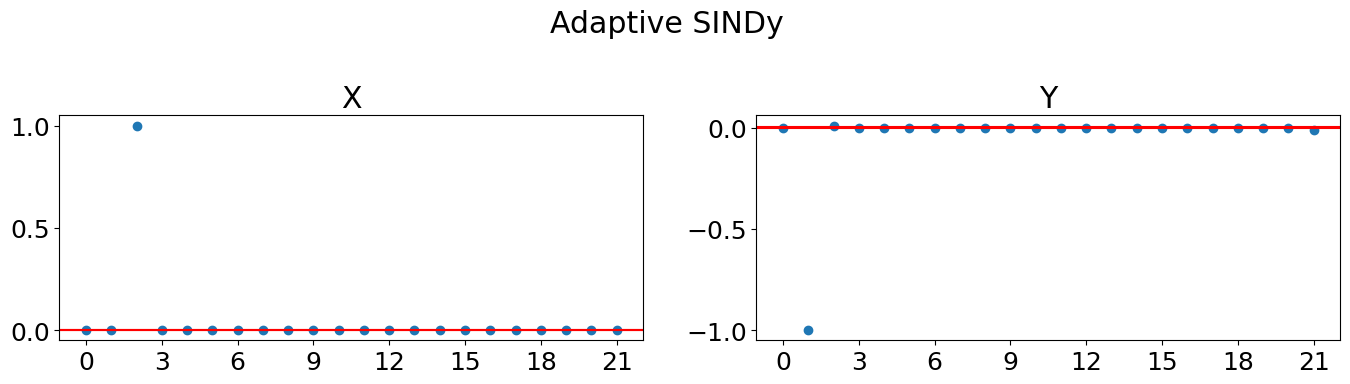

In [10]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o')
ax[1].set_title('Y')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()


In [11]:
print(COEFF_ADT)
print(SINE_ADT )
print(XSINE_ADT)
print(COSINE_ADT)
print(XCOSINE_ADT)
print(EXP_ADT)
print(XEXP_ADT)
print(POWER_ADT)

tensor([[ 0.0000,  0.0000],
        [ 0.0000, -1.0000],
        [ 1.0000,  0.0100],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -0.0100]], device='cuda:0', requires_grad=True)
tensor([[1.7849, 0.5570],
        [1.0688, 1.4178]], device='cuda:0', requires_grad=True)
tensor([[ 0.0000, -0.3097],
        [ 0.2398,  0.0000]], device='cuda:0', requires_grad=True)
tensor([[1.5422, 1.7423],
        [1.4631, 1.6823]], device='cuda:0', requires_grad=True)
tensor([[1.5349, 1.0327],
        [1.5948, 1.4194]], device='cuda:0', re

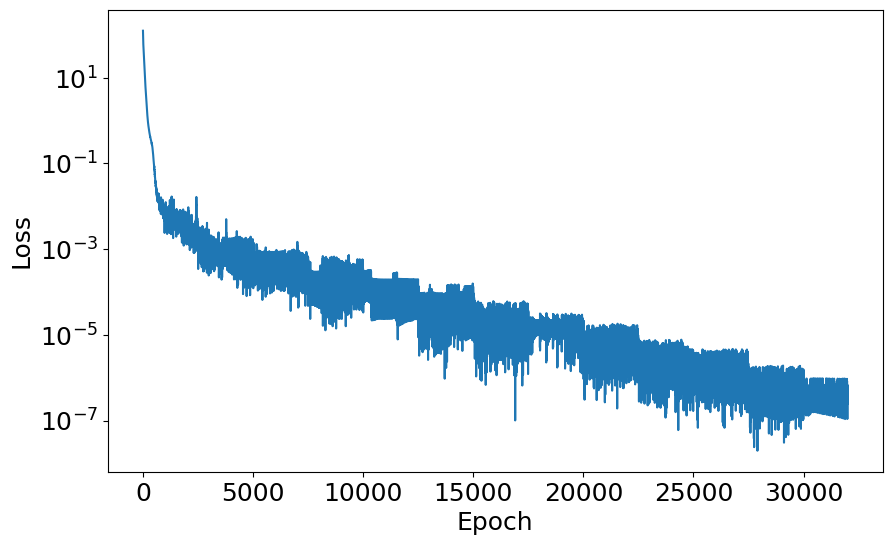

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(False)
plt.savefig('Vander_Loss_plot.jpeg', dpi = 1200)
plt.show()

In [13]:
# --- Export Loss Data to Tecplot Format ---
loss_np = Loss_data.numpy()
epochs = np.arange(len(loss_np))
loss_data = np.column_stack((epochs, loss_np))

# Header for Tecplot
header = 'VARIABLES = "Epoch", "Loss"\nZONE T="Loss Plot", I={}, F=POINT\n'.format(len(epochs))

# Write to .dat with scientific notation
with open('loss_plot_joint_min.dat', 'w') as f:
    f.write(header)
    np.savetxt(f, loss_data, fmt='%.6e', delimiter='\t')

In [14]:
# Convert tensors to numpy arrays
gamma_correct_np = torch.abs(Gamma_correct).numpy()
gamma_incorrect_np = torch.abs(Gamma_incorrect).numpy()

# Stack data as columns: Epoch, Gamma_correct, Gamma_incorrect
epochs = np.arange(len(gamma_correct_np))
data = np.column_stack((epochs, gamma_correct_np, gamma_incorrect_np))

# Define header for Tecplot
header = 'VARIABLES = "Epoch", "Gamma_Correct", "Gamma_Incorrect"\nZONE T="Gamma Plot", I={}, F=POINT\n'.format(len(epochs))

# Write to .dat file
with open('gamma_plot_joint_min.dat', 'w') as f:
    f.write(header)
    np.savetxt(f, data, fmt='%.4e', delimiter='\t')